### Описание проекта:

<a name="b0"> </a>
Данный проект сделан на основе моего "дипломного" проекта при обучении по специальности Data Analyst.  
Основная цель - проверить различные методы машинного обучения для предсказания рейтинга вина на основании различных признаков.   
Побочная цель - продемонстрировать мое владение инструментерием анализа данных и поискать какие-либо интересные закономерности в наборе данных. В частности, я попробую сформулировать рекомендации для вымышленного закупщика условного винного дистрибутора.

Для анализа используется набор данных из **Kaggle**, собранный винным энтузиастом с ником **zackthoutt**, 
https://www.kaggle.com/datasets/zynicide/wine-reviews

Также используются данные **Продовольственной и сельскохозяйственной организации Объединенных Наций** https://www.fao.org/faostat/ru/#home

Выполнение задачи предполагает выполнение следующих этапов исследования:<br>
<a href=#1>1.  Предобработка данных</a><br>
<a href=#2>2.  Исследовательский анализ данных</a><br>
<a href=#3>3.  Анализ рынка вина по регионам.</a><br>
<a href=#4>4.  Исследование зависимости рейтинга вина от цены и других признаков.</a><br>
<a href=#5>5.  Проверка гипотез.</a><br>
<a href=#6>6.  Выводы</a><br>
 

#  <a name="1">1.Предобработка данных</a>

<a href = "#1.1"> 1.1 Загрузка данных</a>  
<a href = "#1.2"> 1.2 Избавление от дубликатов</a>  
<a href = "#1.3"> 1.3 Обработка пропусков</a>  
<a href = "#1.4"> 1.4 Создание новых признаков</a>  

Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

import scipy.stats as st
# импорт библиотеки warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import LabelEncoder # import lable encoder
import copy

plt.rcParams["figure.figsize"] = (15, 6)
sns.set_style('whitegrid', rc = {'figure.figsize':(15, 6)} )
sns.set_context('notebook') 

### <a name="1.1"> </a> 1.1 Загрузка данных 
<a href="#b1"> назад  </a>

In [2]:
wine = pd.read_csv('winemag-data-130k-v2.csv', index_col=0)
wine.head(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [67]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


Количество значений в столбцах различается. Это говорит о том, что в данных есть пустые значения. Признаки points и price числовые, они и будут основными в дальнейшем анализе связей в данных.  

Прежде, чем бороться с пропусками, проанализируем таблицу на наличие дубликатов. 

In [68]:
wine.duplicated().sum()

9983

Почти 10000 полностью дублировенных записей. 
### <a name="1.2"> </a> 1.2 Избавимся от них:
<a href="#b1"> назад  </a>

In [69]:
wine = wine.drop_duplicates()
wine.shape

(119988, 13)

Теперь с помощью библиотеки Seaborn построим тепловую карту для визуализации пропущенных данных.

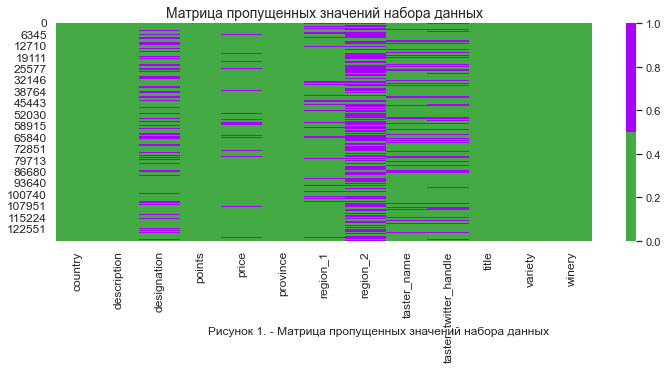

In [70]:
plt.figure(figsize=(12,4))
colours = ['#44aa44', '#aa00ff']
sns.heatmap(wine.isnull(), cmap=sns.color_palette(colours))
# Decorations
plt.title('Матрица пропущенных значений набора данных', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.figtext(0.3, -0.2, "Рисунок 1. - Матрица пропущенных значений набора данных");

Набор данных, используемых для проведения исследования содержит следующие столбцы:
- country: Страна — страна происхождения вина.<br>
- description: Описание — описание вкусового профиля вина.<br>
- designation: Виноградник, ягоды которого используются при изготовлении вина.<br>
- points: Рейтинг — оценка вина, согласно рейтинга журнала Wine Enthusiast, в баллах по шкале от 1 до 100.<br>
- price: Цена — стоимость одной бутылки вина.<br>
- province: Провинция — место изготовления вина (провинция или штат).<br>
- region_1: Регион 1 — винодельческая область в провинции или штате (например, долина Напа в штате Калифорния).<br>
- region_2: Регион 2 — (необязательно) конкретный зона виноделия в винодельческой области (например, Резерфорд в долине Напа).<br>
- taster_name: Имя эксперта, чей отзыв использован.  
- taster_twitter_handle: Твиттер этого эксперта.  
- variety: Сорт винограда, который используется при изготовлении вина (например, Пино Нуар).<br>
- winery: Винодельня — винодельня-производитель вина.<br>

### <a name="1.3"> </a> 1.3 Обработаем пропущенные данные
<a href="#b1"> назад  </a>

In [71]:
wine.isna().mean()

country                  0.000492
description              0.000000
designation              0.287904
points                   0.000000
price                    0.069965
province                 0.000492
region_1                 0.163016
region_2                 0.610219
taster_name              0.207662
taster_twitter_handle    0.245408
title                    0.000000
variety                  0.000008
winery                   0.000000
dtype: float64

Прежде всего, нас интересуют рейтинг (который будем рассматривать как целевой признак) и цена. Как видно, рейтинг указан везде.

В среднем пропущено почти 7% цен. Исследуем зависимости пропусков цены от рейтинга.

In [72]:
wp = wine.groupby('points').price.agg(lambda x: x.isna().mean()).reset_index()

In [73]:
wc = wine.groupby('points').price.count().reset_index()

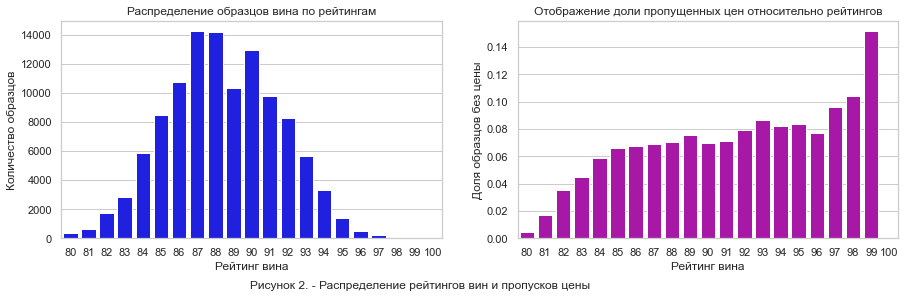

In [74]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
sns.barplot(x = 'points', y='price', data=wc, color = 'b')
plt.title('Распределение образцов вина по рейтингам');
plt.xlabel('Рейтинг вина')
plt.ylabel('Количество образцов')
plt.subplot(1, 2, 2)
sns.barplot(x = 'points', y='price', data=wp, color = 'm')
plt.title('Отображение доли пропущенных цен относительно рейтингов');
plt.xlabel('Рейтинг вина')
plt.ylabel('Доля образцов без цены')
plt.figtext(0.3, -0.05, "Рисунок 2. - Распределение рейтингов вин и пропусков цены");

По рисункам выше видно, что высокая доля пропусков цены у вин с высокими рейтингами. Посмотрим на них внимательнее:

In [75]:
wine[(wine['points'] >= 97) & wine.price.isna()].sort_values(by='points', ascending=False)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
116093,France,98-100 Barrel sample. The aromas are so rich a...,Barrel sample,99,NaN,Bordeaux,Sauternes,NaN,Roger Voss,@vossroger,Château d'Yquem 2009 Barrel sample (Sauternes),Bordeaux-style White Blend,Château d'Yquem
116094,France,"98-100 Barrel sample. Sumptuous, opulent, with...",Barrel sample,99,NaN,Bordeaux,Margaux,NaN,Roger Voss,@vossroger,Château Palmer 2009 Barrel sample (Margaux),Bordeaux-style Red Blend,Château Palmer
116095,France,"98-100 Barrel sample. A superb wine, with the ...",Barrel sample,99,NaN,Bordeaux,Pauillac,NaN,Roger Voss,@vossroger,Château Pontet-Canet 2009 Barrel sample (Paui...,Bordeaux-style Red Blend,Château Pontet-Canet
111758,France,"Stern, almost severe initially, this great win...",NaN,99,NaN,Bordeaux,Pauillac,NaN,Roger Voss,@vossroger,Château Latour 2010 Pauillac,Bordeaux-style Red Blend,Château Latour
111757,France,"A big, bold wine with unbelievable power and c...",NaN,99,NaN,Bordeaux,Saint-Émilion,NaN,Roger Voss,@vossroger,Château Ausone 2010 Saint-Émilion,Bordeaux-style Red Blend,Château Ausone
116096,France,97-99 Barrel sample. A tasting from several ba...,Barrel sample,98,NaN,Bordeaux,Barsac,NaN,Roger Voss,@vossroger,Château Climens 2009 Barrel sample (Barsac),Bordeaux-style White Blend,Château Climens
111762,France,"A dense, smooth and opulent wine bursting with...",NaN,98,NaN,Bordeaux,Pauillac,NaN,Roger Voss,@vossroger,Château Mouton Rothschild 2010 Pauillac,Bordeaux-style Red Blend,Château Mouton Rothschild
111760,France,"Dense, yes, but this is also a handsome wine t...",NaN,98,NaN,Bordeaux,Pauillac,NaN,Roger Voss,@vossroger,Château Pontet-Canet 2010 Pauillac,Bordeaux-style Red Blend,Château Pontet-Canet
111759,France,A great wine that is just starting out. The hi...,NaN,98,NaN,Bordeaux,Margaux,NaN,Roger Voss,@vossroger,Château Margaux 2010 Margaux,Bordeaux-style Red Blend,Château Margaux
109406,Austria,Opulent honey and lemon aromas waft from the g...,Zwischen den Seen Nummer 9 Trockenbeerenauslese,98,NaN,Burgenland,NaN,NaN,Roger Voss,@vossroger,Kracher 2008 Zwischen den Seen Nummer 9 Trocke...,Welschriesling,Kracher


По описанию видно, что большая часть этих вин - образцы, не поступавшие в торговую сеть ("Barrel sample"), и цена на них не определялась. Предлагается исключить их из дальнейшего рассмотрения, т.к. информации о продукции массового сегмента они нам не добавят. Что же касается вин со средними и низкими рейтингами - доля образцов с пропущенными ценами там сравнительно невелика.

**ВЫБРОСИМ записи, где признак price не определен**

In [76]:
wine = wine.dropna(subset='price')

Посмотрим на признак description.

In [77]:
wine.description

1         This is ripe and fruity, a wine that is smooth...
2         Tart and snappy, the flavors of lime flesh and...
3         Pineapple rind, lemon pith and orange blossom ...
4         Much like the regular bottling from 2012, this...
5         Blackberry and raspberry aromas show a typical...
                                ...                        
129966    Notes of honeysuckle and cantaloupe sweeten th...
129967    Citation is given as much as a decade of bottl...
129968    Well-drained gravel soil gives this wine its c...
129969    A dry style of Pinot Gris, this is crisp with ...
129970    Big, rich and off-dry, this is powered by inte...
Name: description, Length: 111593, dtype: object

Это текстовые оценки экспертов. Очень интересно, но для верхнеуровневого исследования рынка, которое мы сейчас проводим, не имеет большой ценности. Избавимся и от этого признака.

In [78]:
wine = wine.drop('description', axis=1)

В признаках designation и region_2 попусков 30% и 60%, вряд ли они нам помогут в дальнейшей работе. Ценную информацию о designation мы уже использовали при анализе цены. Избавимся от этих признаков (от region_1 тоже толку немного, но его жалко).

Наконец, данные об имени и твиттере эксперта нам тоже не добавят ценной информации, сбросим их тоже.

In [79]:
wine = wine.drop(['designation', 'region_2', 'taster_name', 'taster_twitter_handle'], axis=1)
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111593 entries, 1 to 129970
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   country   111538 non-null  object 
 1   points    111593 non-null  int64  
 2   price     111593 non-null  float64
 3   province  111538 non-null  object 
 4   region_1  93580 non-null   object 
 5   title     111593 non-null  object 
 6   variety   111592 non-null  object 
 7   winery    111593 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 7.7+ MB


В некоторых записях пропущены страна и провинция, посмотрим...

In [80]:
wine[wine.country.isna() | wine.province.isna()]

,country,points,price,province,region_1,title,variety,winery
913,NaN,87,30.0,NaN,NaN,Gotsa Family Wines 2014 Asureti Valley Chinuri,Chinuri,Gotsa Family Wines
4243,NaN,88,18.0,NaN,NaN,Kakhetia Traditional Winemaking 2012 Red Natur...,Ojaleshi,Kakhetia Traditional Winemaking
9509,NaN,92,28.0,NaN,NaN,Tsililis 2015 Theopetra Malagouzia-Assyrtiko W...,White Blend,Tsililis
9750,NaN,89,28.0,NaN,NaN,Ross-idi 2015 Orange Nikolaevo Vineyard Chardo...,Chardonnay,Ross-idi
11150,NaN,89,20.0,NaN,NaN,Orbelus 2013 Melnik,Melnik,Orbelus
14030,NaN,88,25.0,NaN,NaN,St. Donat 2013 Márga White,White Blend,St. Donat
16000,NaN,86,40.0,NaN,NaN,Familia Deicas 2015 Valle de los Manantiales V...,Tannat,Familia Deicas
18075,NaN,90,17.0,NaN,NaN,Tsililis 2015 Askitikos Assyrtiko,Assyrtiko,Tsililis
26485,NaN,87,13.0,NaN,NaN,Stone Castle 2013 Shiraz,Shiraz,Stone Castle
26486,NaN,87,14.0,NaN,NaN,Teliani Valley 2015 Tsolikouri,Tsolikouri,Teliani Valley


Для некоторых можно определить страну по сорту винограда или названию виноградника, но общее число настолько невелико, что не стоит потраченного времени. Просто выбросим эти записи.

In [81]:
wine.dropna(subset='country', inplace=True)
wine.dropna(subset='variety', inplace=True) #одна запись затесалась с пропущенным сортом
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111537 entries, 1 to 129970
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   country   111537 non-null  object 
 1   points    111537 non-null  int64  
 2   price     111537 non-null  float64
 3   province  111537 non-null  object 
 4   region_1  93580 non-null   object 
 5   title     111537 non-null  object 
 6   variety   111537 non-null  object 
 7   winery    111537 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 7.7+ MB


**В ИТОГЕ** мы получили для дальнейшей работы набор данных без дублей и без пропусков в ключевых признаках.

### <a name="1.4"> </a> 1.4 Создадим новые признаки
<a href="#b1"> назад  </a>

**Для удобства** дальнейшей работы добавим новый признак **logprice** - десятичный логарифм цены. Это упростит построение визуализаций и работу с моделями.

In [82]:
wine['logprice'] = np.log10(wine.price)

Пользуюясь словерем, приведенным ниже, добавим признак КОНТИНЕНТ

In [83]:
# Словарь соответствия стран континентам
country_to_continent = {
'Montenegro':'Europe',
'South Korea': 'Asia',
'Italy':'Europe',
'Portugal':'Europe',
'US':'North America',
'Spain':'Europe',
'France':'Europe',
'Germany':'Europe',
'Argentina':'Latin America',
'Chile':'Latin America',
'Australia': 'Oceania',
'Austria': 'Europe',
'South Africa': 'Africa',
'New Zealand': 'Oceania',
'Israel': 'Asia',
'Hungary':'Europe',
'Greece':'Europe',
'Romania':'Europe',
'Mexico':'Latin America',
'Canada':'North America',
'Turkey': 'Asia',
'Czech Republic': 'Europe',
'Slovenia': 'Europe',
'Luxembourg': 'Europe',
'Croatia': 'Europe',
'Georgia':'Europe',
'Uruguay': 'Latin America',
'England': 'Europe',
'Lebanon': 'Asia',
'Serbia': 'Europe',
'Brazil': 'Latin America',
'Moldova': 'Europe',
'Morocco':'Africa',
'Peru':'Latin America',
'India':'Asia',
'Bulgaria':'Europe',
'Cyprus': 'Europe',
'Armenia':'Asia',
'Switzerland':'Europe',
'Bosnia and Herzegovina':'Europe',
'Ukraine':'Europe',
'Slovakia':'Europe',
'Macedonia':'Europe',
'China':'Asia',
'Egypt':'Africa'
}

In [84]:
wine['continent'] = wine['country'].map(country_to_continent)
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111537 entries, 1 to 129970
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   country    111537 non-null  object 
 1   points     111537 non-null  int64  
 2   price      111537 non-null  float64
 3   province   111537 non-null  object 
 4   region_1   93580 non-null   object 
 5   title      111537 non-null  object 
 6   variety    111537 non-null  object 
 7   winery     111537 non-null  object 
 8   logprice   111537 non-null  float64
 9   continent  111537 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 9.4+ MB


**Континенты** все на месте. Создадим признак **Цвет**, базируясь на базовом словаре сортов винограда, приведенном ниже.

In [85]:
#Словарь соответствия цвета вина сортам винограда

color = {
    "Chardonnay": "white",
    "Pinot Noir": "red",
    "Cabernet Sauvignon": "red",
    "Red Blend": "red",
    "Bordeaux-style Red Blend": "red",
    "Sauvignon Blanc": "white",
    "Syrah": "red",
    "Riesling": "white",
    "Merlot": "red",
    "Zinfandel": "red",
    "Sangiovese": "red",
    "Malbec": "red",
    "White Blend": "white",
    "Rosé": "other",
    "Tempranillo": "red",
    "Nebbiolo": "red",
    "Portuguese Red": "red",
    "Sparkling Blend": "other",
    "Shiraz": "red",
    "Corvina, Rondinella, Molinara": "red",
    "Rhône-style Red Blend": "red",
    "Barbera": "red",
    "Pinot Gris": "white",
    "Viognier": "white",
    "Bordeaux-style White Blend": "white",
    "Champagne Blend": "other",
    "Port": "red",
    "Grüner Veltliner": "white",
    "Gewürztraminer": "white",
    "Portuguese White": "white",
    "Petite Sirah": "red",
    "Carmenère": "red"
}

In [86]:
wine['color'] = wine['variety'].map(color)
wine.isna().sum()

country          0
points           0
price            0
province         0
region_1     17957
title            0
variety          0
winery           0
logprice         0
continent        0
color        21126
dtype: int64

В цвете много пропущенных значений. Посмотрим, что можно с этим сделать:

In [87]:
wine[wine.color.isna()].variety.value_counts().head(15)

Cabernet Franc             1195
Pinot Grigio                934
Gamay                       749
Grenache                    604
Glera                       552
Tempranillo Blend           548
Sangiovese Grosso           545
Chenin Blanc                492
Albariño                    432
Rhône-style White Blend     388
Pinot Blanc                 345
Garnacha                    307
Moscato                     302
Nero d'Avola                289
Aglianico                   274
Name: variety, dtype: int64

Видно, что, добавив в словарь хотя бы несколько сортов, мы существенно улучшим результат. Приведем словарь к виду, удобному для экспертной обработки:

In [88]:
wine[wine.color.isna()].variety.value_counts().index[:35]

Index(['Cabernet Franc', 'Pinot Grigio', 'Gamay', 'Grenache', 'Glera',
       'Tempranillo Blend', 'Sangiovese Grosso', 'Chenin Blanc', 'Albariño',
       'Rhône-style White Blend', 'Pinot Blanc', 'Garnacha', 'Moscato',
       'Nero d'Avola', 'Aglianico', 'Sauvignon', 'Verdejo', 'Petit Verdot',
       'Meritage', 'Torrontés', 'Melon', 'Mourvèdre', 'Garganega', 'Prosecco',
       'Primitivo', 'Blaufränkisch', 'Montepulciano', 'Vermentino', 'G-S-M',
       'Zweigelt', 'Mencía', 'Roussanne', 'Dolcetto', 'Tinta de Toro',
       'Touriga Nacional'],
      dtype='object')

...и выполним экспертную оценку (знания с опытом + интернет).

In [89]:
newreds = ['Sangiovese Grosso', 'Tempranillo Blend', 'Grenache', 'Garnacha',
       'Nero d"Avola', 'Dolcetto', 'Gamay','Cabernet Blend', 'Pinotage', 'Sauvignon', 
        'Montepulciano', 'Aglianico', 'Mourvèdre',
       'Zweigelt', 'Primitivo', 'Cabernet Sauvignon-Merlot', 'Tinta de Toro', 'Blaufränkisch',
           'Petit Verdot','Nero d"Avola', 'Touriga Nacional', 'Mencía']

In [90]:
newwhites = ['Cabernet Franc', 'Pinot Grigio', 'Chenin Blanc', 'Albariño', 
       'Pinot Blanc', 'Moscato', 'Prosecco', 'Torrontés', 'Rhône-style White Blend', 
       'Garganega', 'Verdejo', 'Sauvignon', 'Sémillon', 'Glera', 'Melon', 'Vermentino', 'Roussanne']

Добавим новые сорта в словарь:

In [91]:
for red in newreds:
    color[red]='red'

for white in newwhites:
    color[white]='white'  

In [92]:
wine['color'] = wine['variety'].map(color)
wine.isna().sum()

country          0
points           0
price            0
province         0
region_1     17957
title            0
variety          0
winery           0
logprice         0
continent        0
color         9489
dtype: int64

Количество нераспознанных цветов уменьшилось в 2.5 раза. Остановимся на этом. Присвоим нераспознанным цветам значение 'other'

In [93]:
wine['color'] = wine['color'].fillna('other')

**ИТОГ:** данные очищены от дубликатов и от пропусков в ключевых признаках, добавлено разбиение по регионам (континентам) и по цвету вина, добавлена логарифмированная цена.

#  <a name="2"> 2. Исследовательский анализ данных</a>
<a href="#b0"> назад </a> 

<a name = "b2"> </a>
<a href = "#2.1"> 2.1 Проанализировать данные с точки зрения представленности стран и регионов.</a>  
<a href = "#2.2"> 2.2 Найти популярные сорта по регионам.</a>  
<a href = "#2.3"> 2.3 Выбрать сорта с наибольшими ценами. Найти средние цены вина по регионам.</a>  
<a href = "#2.4"> 2.4 Определить популярные сорта вина в бюджетном сегменте.</a>  
<a href = "#2.5"> 2.5 Определить, какие сорта вина лидируют по рейтингам.</a>  
<a href = "#2.6"> 2.6 Построить график «ящик с усами» по рейтингам в разбивке по странам, по сортам вина.</a>  
<a href = "#2.7"> 2.7 Выявить закономерность влияния на цену цвета и рейтинга. Построить диаграмму рассеяния и посчитать корреляцию. </a> 



<h3><a name = "2.1"> 2.1 Проанализировать данные с точки зрения представленности стран и регионов.</a>  </h3>
<a href = "#2"> назад </a>

Посмотрим, как именно распределены представленные образцы вина по странам (TOP-10) и по континентам:

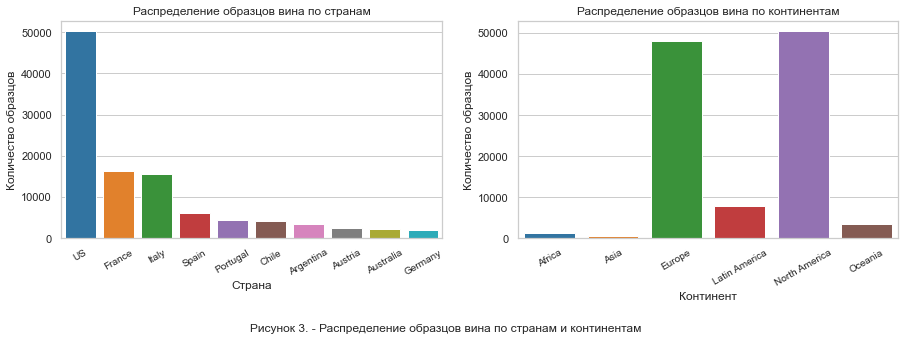

In [94]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
sns.barplot(x='country', y='points', data=wine.groupby('country').\
            points.count().sort_values(ascending=False)[:10].reset_index())
plt.xticks(rotation=30, fontsize=10)
plt.title('Распределение образцов вина по странам');
plt.xlabel('Страна')
plt.ylabel('Количество образцов')

plt.subplot(1, 2, 2)
sns.barplot(x='continent', y='points', data=wine.groupby('continent').\
            points.count().reset_index());
plt.xticks(rotation=30, fontsize=10);
plt.title('Распределение образцов вина по континентам');
plt.xlabel('Континент')
plt.ylabel('Количество образцов');

plt.figtext(0.3, -0.2, "Рисунок 3. - Распределение образцов вина по странам и континентам");

Представленная картина выглядит несколько неожиданно ввиду высокой доли США.  
Давайте сопоставим ее с общими данными по мировому производству вина. Эти данные можно найти и загрузить на сайте  
**Продовольственная и сельскохозяйственная организация Объединенных Наций** https://www.fao.org/faostat/ru/#home 

Возьмем там данные по объемам производства вина с 2016 по 2019 годы.

In [95]:
undata = pd.read_csv('../data/FAOSTAT_data_wine_2016-2020.csv')
undata.head(2)

,Domain,Area,Element,Item,Year,Unit,Value
0,Crops and livestock products,Albania,Production,Wine,2016,tonnes,17800.0
1,Crops and livestock products,Albania,Production,Wine,2017,tonnes,16868.0


Посмотрим TOP-10 винопроизводящих стран по данным ООН:

In [96]:
undata.groupby('Area').Value.sum().sort_values()[-1:-11:-1].reset_index()

,Area,Value
0,Italy,19881982.0
1,France,17195707.0
2,Spain,14990000.0
3,United States of America,9858776.0
4,"China, mainland",7794347.0
5,China,7794347.0
6,Australia,5150000.0
7,Argentina,4880859.0
8,Chile,4447341.0
9,South Africa,4058900.0


China встречается дважды с одинаковыми цифрами (по-видимому, наследие присутствия в ООН Тайваня в прошлом веке). Уберем лишние данные:

In [97]:
undata = undata[undata['Area'] != 'China, mainland']
undata.loc[undata['Area']=='United States of America', 'Area'] = "US" #и укоротим США для красоты отображния
undata.shape

(283, 7)

Выделим TOP-10 стран-винопроизводителей:

In [98]:
TOP10list=list(undata.groupby('Area').Value.sum().sort_values()[-1:-11:-1].index)
unTOP10 = undata.query('Area in @TOP10list')
unTOP10.Area.unique()

array(['Argentina', 'Australia', 'Chile', 'China', 'France', 'Italy',
       'Portugal', 'South Africa', 'Spain', 'US'], dtype=object)

И посмотрим на их объемы производства:

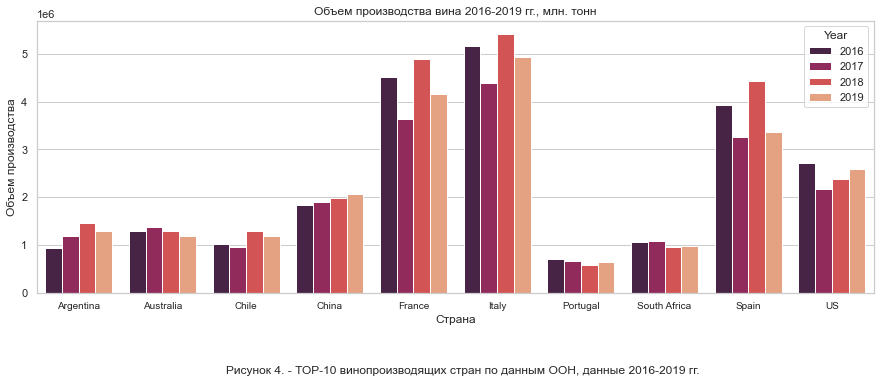

In [99]:
plt.figure(figsize=(15, 5))
sns.barplot(x='Area', y='Value', hue='Year', palette='rocket', data=unTOP10)
plt.xticks(rotation=0, fontsize=10)
plt.title('Объем производства вина 2016-2019 гг., млн. тонн');
plt.xlabel('Страна')
plt.ylabel('Объем производства')
plt.figtext(0.3, -0.1, "Рисунок 4. - ТОР-10 винопроизводящих стран по данным ООН, данные 2016-2019 гг.");

**ВЫВОД**  
В наших данных по рейтингу вин представленность стран не соответствует их значимости в мировом производстве вина, что, по-видимому, связано с американским происходжением этих данных. В частности, доля образцов из США непропорционально велика и никак не соответствует месту США в мировом производстве вина. 

При этом три основных мировых производителя (Италия, Франция, Испания) представлены достаточно широко и адекватно, да и вообще из крупных производителей плохо представлен только Китай. Что, по-видимому, связано с тем, что емкий внутренний рынок этой страны потребляет всё, что производится и экспорт незначителен.

<h3><a name= "2.2">2.2 Найти популярные сорта по регионам.</a> </h3> 
<a href="#2"> назад </a>

Найдем популярные сорта по континентам:

In [101]:
def TOP_list(data, top=3):
    lst=list(data.value_counts()[:top].index)
    return lst

top_variety_cont = wine.groupby(['continent']).variety.agg(lambda x: TOP_list(x, 3))

In [102]:
for ind, val in top_variety_cont.items():
    print('Регион:{:^15} Популярные сорта винограда: '.format(ind), end='')
    print(*val, sep=', ')

Регион:    Africa      Популярные сорта винограда: Sauvignon Blanc, Chenin Blanc, Chardonnay
Регион:     Asia       Популярные сорта винограда: Red Blend, Cabernet Sauvignon, Chardonnay
Регион:    Europe      Популярные сорта винограда: Red Blend, Bordeaux-style Red Blend, Riesling
Регион: Latin America  Популярные сорта винограда: Malbec, Cabernet Sauvignon, Chardonnay
Регион: North America  Популярные сорта винограда: Pinot Noir, Cabernet Sauvignon, Chardonnay
Регион:    Oceania     Популярные сорта винограда: Shiraz, Pinot Noir, Sauvignon Blanc


Найдем популярные сорта по крупнейшим странам-винопроизводителям:

In [103]:
top_variety_country = wine[wine.country.isin(TOP10list)].groupby(['country']).variety.agg(lambda x: TOP_list(x, 3))

for ind, val in top_variety_country.items():
    print('Страна: {:<13} Популярные сорта винограда: '.format(ind), end='')
    print(*val, sep=', ')

Страна: Argentina     Популярные сорта винограда: Malbec, Cabernet Sauvignon, Chardonnay
Страна: Australia     Популярные сорта винограда: Shiraz, Chardonnay, Cabernet Sauvignon
Страна: Chile         Популярные сорта винограда: Cabernet Sauvignon, Sauvignon Blanc, Carmenère
Страна: China         Популярные сорта винограда: Cabernet Blend
Страна: France        Популярные сорта винограда: Bordeaux-style Red Blend, Chardonnay, Rosé
Страна: Italy         Популярные сорта винограда: Red Blend, Nebbiolo, Sangiovese
Страна: Portugal      Популярные сорта винограда: Portuguese Red, Portuguese White, Port
Страна: South Africa  Популярные сорта винограда: Sauvignon Blanc, Chenin Blanc, Chardonnay
Страна: Spain         Популярные сорта винограда: Tempranillo, Red Blend, Tempranillo Blend
Страна: US            Популярные сорта винограда: Pinot Noir, Cabernet Sauvignon, Chardonnay


**ВЫВОД** Как правило, популярные сорта винограда специфичны для региона. Хотя некоторые сорта, такие, как Шардоне и Каберне Совиньон, широко распространены по всему миру.

<h3><a name= "2.3"> 2.3 Выбрать сорта с наибольшими ценами. Найти средние цены вина по регионам.</a>  </h3>
<a href="#2"> назад </a>

Найдем сорта винограда, из которых изготовлены самые дорогие вина.

In [104]:
print('Сорта винограда, из которых изготовлены самые дорогие вина: ', end='')
print( *wine.groupby('variety').price.max().sort_values(ascending=False).index[:3], sep=', ')

Сорта винограда, из которых изготовлены самые дорогие вина: Bordeaux-style Red Blend, Pinot Noir, Chardonnay


Рассмотрим теперь популярные сорта винограда, представленные не менее 500 раз, и составим их рейтинг по максимальной стоимости вина.

In [111]:
win_var_list= wine.variety.value_counts()
variety_500more = win_var_list[win_var_list > 500].index
variety_500more

Index(['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 'Red Blend',
       'Bordeaux-style Red Blend', 'Riesling', 'Sauvignon Blanc', 'Syrah',
       'Rosé', 'Merlot', 'Zinfandel', 'Malbec', 'Sangiovese', 'Nebbiolo',
       'Portuguese Red', 'White Blend', 'Sparkling Blend', 'Tempranillo',
       'Rhône-style Red Blend', 'Pinot Gris', 'Cabernet Franc',
       'Champagne Blend', 'Grüner Veltliner', 'Pinot Grigio', 'Viognier',
       'Portuguese White', 'Gewürztraminer', 'Shiraz', 'Gamay', 'Petite Sirah',
       'Bordeaux-style White Blend', 'Grenache', 'Glera', 'Tempranillo Blend',
       'Barbera', 'Sangiovese Grosso', 'Carmenère'],
      dtype='object')

In [112]:
wine[wine.variety.isin(variety_100more)].groupby('variety').\
price.agg(['max','count']).sort_values(by='max', ascending=False).head(10)

,max,count
variety,,
Bordeaux-style Red Blend,3300.0,4958
Pinot Noir,2500.0,11833
Chardonnay,2013.0,10235
Grüner Veltliner,1100.0,1019
Bordeaux-style White Blend,1000.0,635
Sangiovese Grosso,900.0,545
Shiraz,850.0,775
Sangiovese,800.0,2163
Rosé,800.0,2950


**ВЫВОД** как видно, сорта, из которых изготавливаются самые дорогие сорта вина, являются также и популярными.  

Посмотрим распределение цен на вина из винограда Chardonnay, которые является и одним из самых популярных, и дает одно из самых дорогих вин в нашем списке. Ввиду большого разброса цен, будем смотреть на логарифм цены.

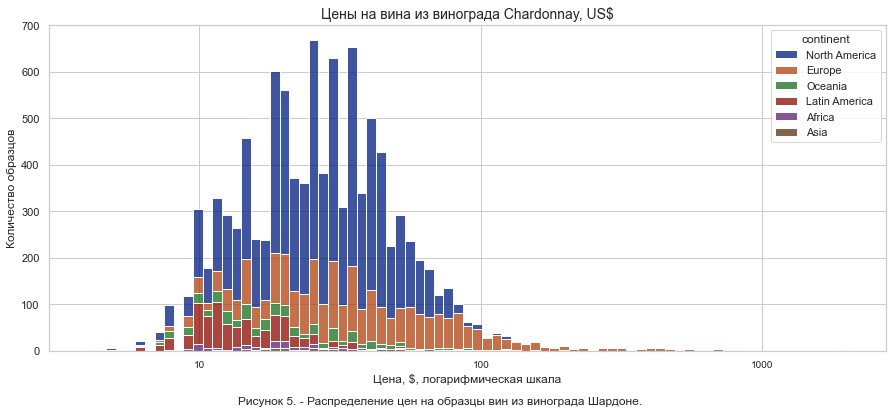

In [113]:
sns.histplot(x='logprice', data=wine[wine.variety == 'Chardonnay'], hue='continent', multiple='stack', palette='dark')
plt.xticks(ticks=[1, 2, 3], labels = ['10', '100', '1000'], rotation=0, fontsize=10);
plt.title('Цены на вина из винограда Chardonnay, US$', fontsize=14);
plt.xlabel('Цена, $, логарифмическая шкала')
plt.ylabel('Количество образцов')
plt.figtext(0.3, -0.0, "Рисунок 5. - Распределение цен на образцы вин из винограда Шардоне.");

**ВЫВОД** На примере сорта Шардоне видно, что одни и те же популярные сорта винограда могут использоваться для изготовления вин различных ценовых диапазонов в различных регионах.

<h3><a name= "2.4"> 2.4 Определить популярные сорта вина в бюджетном сегменте.</a>  </h3>
<a href="#2"> назад </a>

Исследуем цены вин в разбивке по регионам(континентам), чтобы определить границы "бюджетности". Для визуализации данных лимитируем сверху суммой $80, т.к. нам интересен нижний сегмент.

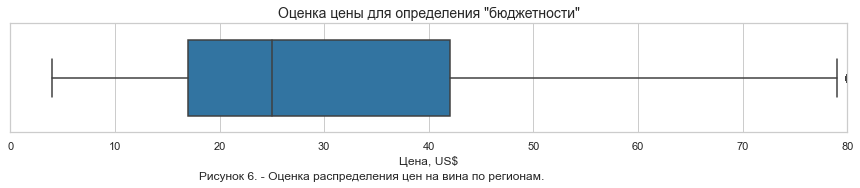

In [114]:
plt.figure(figsize = (15, 2))
sns.boxplot(x='price', data=wine, width = 0.7)
plt.xlim(0, 80)
plt.title('Оценка цены для определения "бюджетности"', fontsize=14);
plt.xlabel('Цена, US$'); plt.ylabel('')
plt.figtext(0.3, -0.2, "Рисунок 6. - Оценка распределения цен на вина по регионам.");

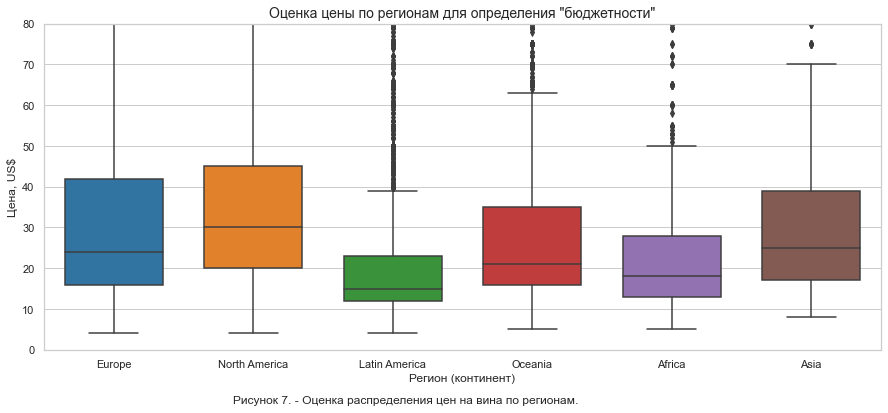

In [115]:
sns.boxplot(y='price', x='continent', data=wine, width = 0.7)
plt.ylim(0, 80)
plt.title('Оценка цены по регионам для определения "бюджетности"', fontsize=14);
plt.xlabel('Регион (континент)'); plt.ylabel('Цена, US$')
plt.figtext(0.3, -0.0, "Рисунок 7. - Оценка распределения цен на вина по регионам.");

Представляется разумным за границу "бюджетности" взять отметку $20. Посмотрим, какая доля образцов попадет в эти границы: 

In [116]:
print('В диапазоне дешевле $20 находится', round((wine.price < 20).mean()*100, 0), '%образцов')

В диапазоне дешевле $20 находится 33.0 %образцов


33% - вполне достаточно, чтобы рассматривать "бюджетными". Посмотрим, какие сорта винограда популярны для бюджетных сортов в разбивке по континентам.

In [117]:
wine_cheap = wine.query('price <= 20')
wine_cheap = wine_cheap.groupby(['continent', 'color']).variety.\
     agg(lambda x: x.value_counts().index[0]).unstack().reset_index(col_level=0)

In [118]:
for _, row in wine_cheap.iterrows():
        print('Континент: {:<14s} популярный бюджетный красный: {:20s} белый: {}'.
              format(row['continent'], row['red'], row['white']))
    
    
#    print('Регион:{:^15} Популярный бюджетный сорт: '.format(row['continent']))

Континент: Africa         популярный бюджетный красный: Pinotage             белый: Sauvignon Blanc
Континент: Asia           популярный бюджетный красный: Cabernet Sauvignon   белый: Chardonnay
Континент: Europe         популярный бюджетный красный: Red Blend            белый: Riesling
Континент: Latin America  популярный бюджетный красный: Cabernet Sauvignon   белый: Chardonnay
Континент: North America  популярный бюджетный красный: Cabernet Sauvignon   белый: Chardonnay
Континент: Oceania        популярный бюджетный красный: Shiraz               белый: Sauvignon Blanc


**ВЫВОД** Список популярных сортов винограда для изготовления красного и белого вина в разбивке по континентам приведен выше.  
Наиболее популярны Каберне Совиньон для красных и Шардоне для белых вин. Заметим, что, как показано выше для Шардоне, это не исключает изготовления дорогих вин из того же сорта винограда.

<h3><a name= "2.5"> 2.5 Определить, какие сорта вина лидируют по рейтингам.</a>  </h3>
<a href="#2"> назад </a>

Начнем с построения распределения (гистограммы) рейтингов вин.

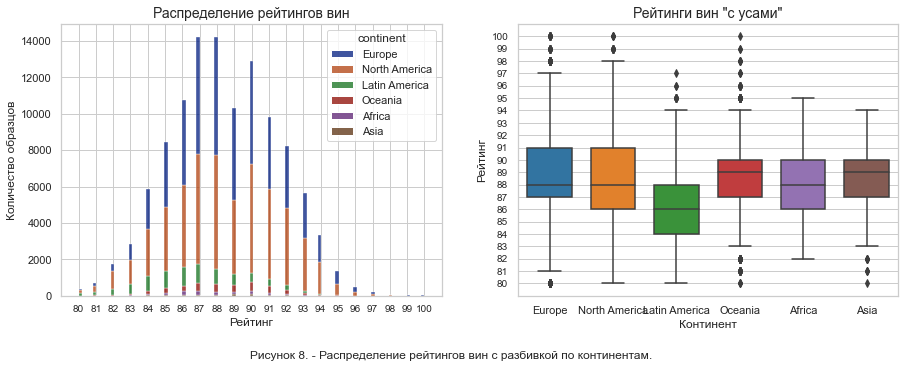

In [119]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(x='points', data=wine, hue='continent', multiple='stack', palette='dark')
plt.xticks(ticks=np.arange(80, 101).astype(int), rotation=0, fontsize=10);
plt.title('Распределение рейтингов вин', fontsize=14);
plt.xlabel('Рейтинг')
plt.ylabel('Количество образцов')

plt.subplot(1, 2, 2)
sns.boxplot(x='continent', y='points', data=wine, width=0.7)
plt.yticks(ticks=np.arange(80, 101).astype(int), fontsize=10);
plt.title('Рейтинги вин "с усами"', fontsize=14);
plt.xlabel('Континент')
plt.ylabel('Рейтинг')


plt.figtext(0.3, -0.05, "Рисунок 8. - Распределение рейтингов вин с разбивкой по континентам.");

Проанализировав распределение выше, задачу можно сформулировать как: "какие сорта винограда лидируют среди вин с рейтингами выше 95". Рассмотрим эту картинку (вина с рейтингом выше 95) подробнее.

In [120]:
wine95 = wine.query('points >= 95')

In [121]:
print('Сорта, дающие наибольшее количество вин с высокой оценкой: ', end="") 
print(*wine95.groupby(['variety']).country.count().nlargest(3).index, sep=', ')

Сорта, дающие наибольшее количество вин с высокой оценкой: Pinot Noir, Cabernet Sauvignon, Chardonnay


Сформулируем вопрос (и ответ) иначе, базируясь только на максимальной оценке:

In [122]:
print('Сорта, давшие вина с максимальной оценкой (из доступных к покупке): ', end="") 
print(*wine[wine['points']==100].variety, sep=', ')

Сорта, давшие вина с максимальной оценкой (из доступных к покупке): Muscat, Prugnolo Gentile, Champagne Blend, Merlot, Portuguese Red, Sangiovese, Cabernet Sauvignon, Bordeaux-style Red Blend, Champagne Blend, Chardonnay, Bordeaux-style Red Blend, Sangiovese Grosso, Bordeaux-style Red Blend, Bordeaux-style Red Blend, Syrah, Port, Bordeaux-style Red Blend, Bordeaux-style White Blend, Syrah



<h3><a name= "2.6"> 2.6 Построить график «ящик с усами» по рейтингам в разбивке по странам, по сортам вина.</a>  </h3>

<a href="#2"> назад </a>

Частично эта задача уже выполнялась ранее, но посмотрим на картину в целом:

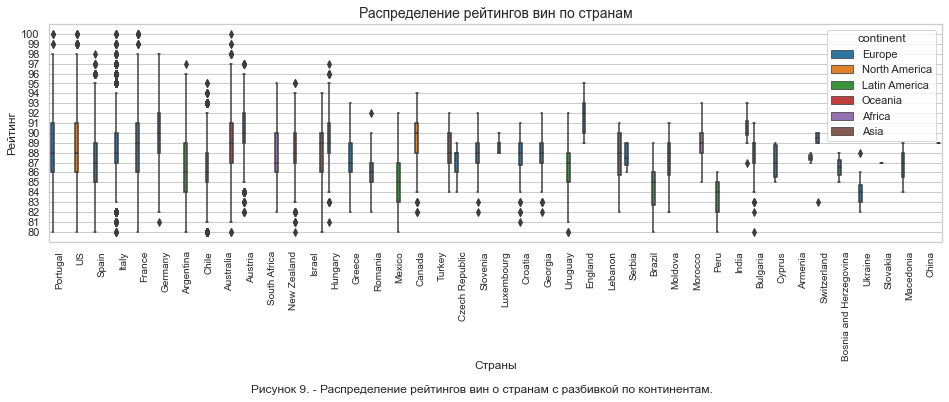

In [123]:
plt.figure(figsize=(16, 4))
sns.boxplot(x='country', y='points', data=wine, hue='continent');
plt.xticks(rotation=90, fontsize=10);
plt.yticks(ticks=range(80, 101))
plt.title('Распределение рейтингов вин по странам', fontsize=14);
plt.xlabel('Страны', labelpad = 0)
plt.ylabel('Рейтинг');
plt.figtext(0.3, -0.4, "Рисунок 9. - Распределение рейтингов вин о странам с разбивкой по континентам.");

Картинка получается перегруженной и сложной для восприятия, ограничим ее TOP20:

In [124]:
wine_top20countries = list(wine.value_counts('country').index[:20])

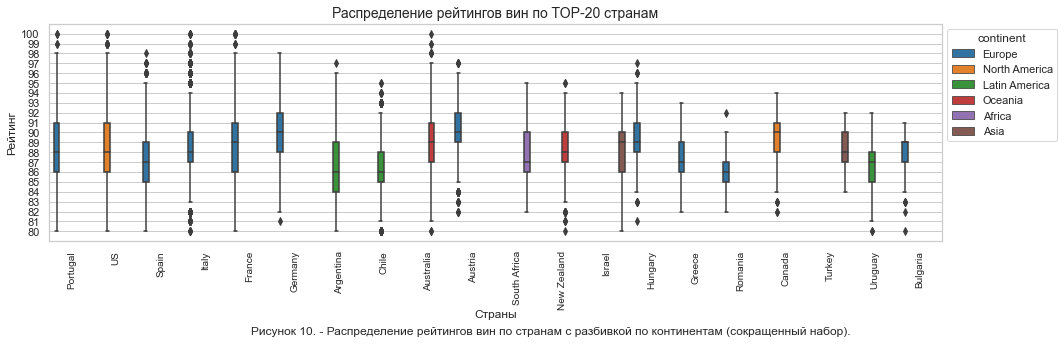

In [128]:
plt.figure(figsize=(16, 4))
ax=sns.boxplot(x='country', y='points', data=wine[wine['country'].isin(wine_top20countries)], hue='continent');
plt.xticks(rotation=90, fontsize=10);
plt.yticks(ticks=range(80, 101))
plt.title('Распределение рейтингов вин по TOP-20 странам', fontsize=14);
plt.xlabel('Страны', labelpad = 0)
plt.ylabel('Рейтинг');
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.figtext(0.3, -0.2, "Рисунок 10. - Распределение рейтингов вин по странам с разбивкой по континентам (сокращенный набор).");

### Визуализируем такую же зависимость по сортам винограда, сразу ограничив TOP30:

In [129]:
wine_top30varietes = list(wine.value_counts('variety').index[:30])

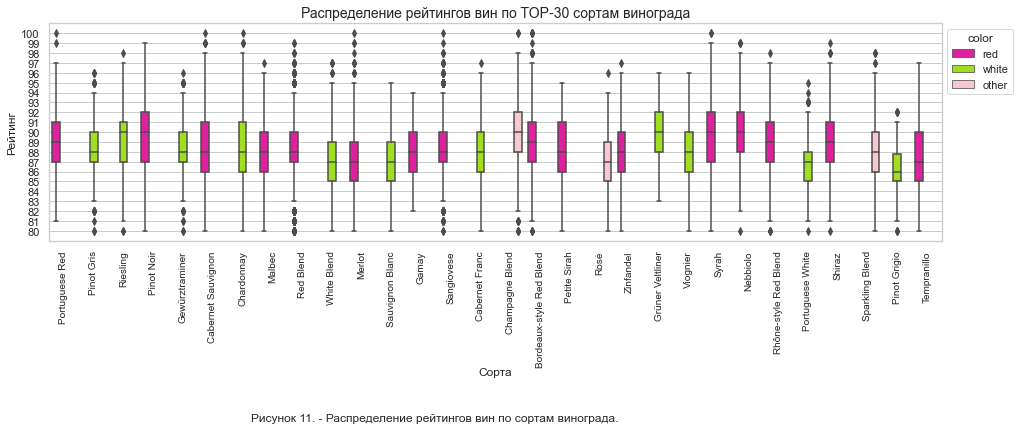

In [130]:
winpalette = {'red':'#ff00aa' , 'white':'#aaff00', 'other':'pink'}

plt.figure(figsize=(16, 4))
ax=sns.boxplot(x='variety', y='points', data=wine[wine['variety'].isin(wine_top30varietes)], hue='color', 
            palette=winpalette);
plt.xticks(rotation=90, fontsize=10);
plt.yticks(ticks=range(80, 101))
plt.title('Распределение рейтингов вин по TOP-30 сортам винограда', fontsize=14);
plt.xlabel('Сорта', labelpad = 0)
plt.ylabel('Рейтинг');
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.figtext(0.3, -0.5, "Рисунок 11. - Распределение рейтингов вин по сортам винограда.");

**ВЫВОД**  
Высших рейтингов ожидаемо (для данного обзора) достигают вина крупнейших европейских производителей, США и Австралии. Неожиданным являются лишь сравнительно низкие как максимальные, так и медианные оценки для Испании.  
Кроме того, внимания заслуживает факт самый высоких медианных оценок (90) вин Австрии и Германии. 

В графике по сортам винограда можно обратить внимание разве что на стабильно высокие оценки "региональных" сортов, таких, как испанский сорт Nebbiolo, немецко-австрийский Gruener Veltliner, французский Champagne Blend.

<h3><a name= "2.7"> 2.7 Выявить закономерность влияния на цену цвета и рейтинга. <br> Построить диаграмму рассеяния и посчитать корреляцию. </a>  </h3>
<a href="#2"> назад </a>

Визуализируем зависимость между ценой (логарифмированной), рейтингом и цветом. Т.к. про цвет 'other' мы почти ничего не знаем, временно исключим его из анализа.

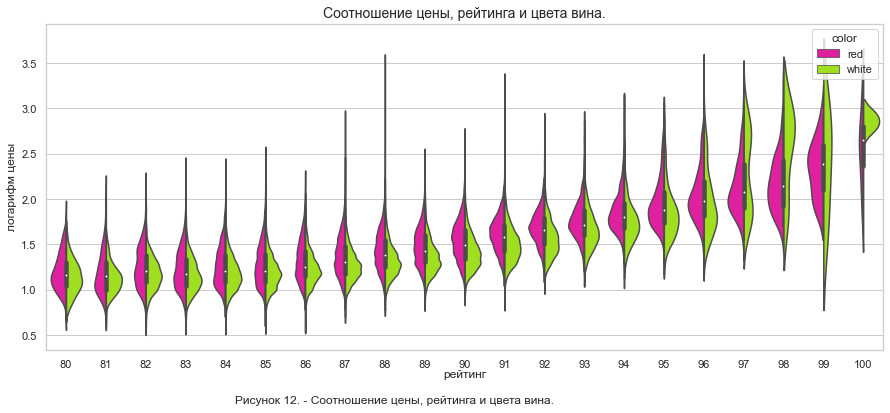

In [131]:
wine_rw = wine.query("color in ['red', 'white']")
sns.violinplot(x='points', y='logprice', data=wine_rw, 
               hue='color', palette=winpalette, split=True);
plt.title('Соотношение цены, рейтинга и цвета вина.', fontsize=14);
plt.xlabel('рейтинг', labelpad = 0)
plt.ylabel('логарифм цены');
plt.figtext(0.3, -0.0, "Рисунок 12. - Соотношение цены, рейтинга и цвета вина.");


По визуализации выше видно, что связь меджу ценой и рейтингом, скорее всего, существует, а вот о влиянии цвета вина на это соотношение сделать какой-то вывод затруднительно.

Посмотрим еще одну визуализацию:

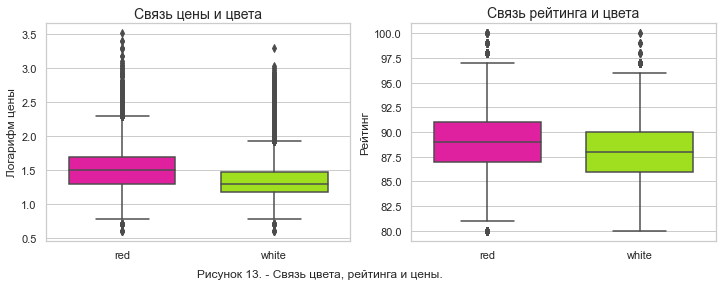

In [132]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.boxplot(data=wine_rw, y='logprice', x='color', palette=winpalette, width=0.7);
plt.title('Связь цены и цвета', fontsize=14);
plt.ylabel('Логарифм цены');
plt.xlabel('');
plt.subplot(1, 2, 2)
sns.boxplot(data=wine_rw, y='points', x='color', palette=winpalette, width=0.7);
plt.title('Связь рейтинга и цвета', fontsize=14);
plt.ylabel('Рейтинг');
plt.xlabel('');
plt.figtext(0.3, -0.0, "Рисунок 13. - Связь цвета, рейтинга и цены.");

Эта визуализация показывает, что, хотя белые вина в среднем дешевле, однозначной связи между цветом и рейтингом нет, и влияние цвета на соотношение "цена-рейтинг" не очевидно. 

Посмотрим корреляцию между числовыми признаками. Параметр logprice (десятичный логарифм цены) также будет в рассмотрении.

In [133]:
wine.corr()

,points,price,logprice
points,1.000000,0.416561,0.617684
price,0.416561,1.000000,0.727259
logprice,0.617684,0.727259,1.000000


Мы видим умеренную (0.42) положительную корреляцию между рейтингом и ценой и более высокую (0.62) между рейтингом и логарифмом цены. Посмотрим, улучшится ли корреляция при выделении отдельно белого и красного вина  (для компактности оставим только логарифмированную цену):

In [134]:
wine.drop('price', axis=1).groupby('color').corr().T

color        other                 red              white         
            points  logprice    points  logprice   points logprice
points    1.000000  0.595297  1.000000  0.616558  1.00000  0.62313
logprice  0.595297  1.000000  0.616558  1.000000  0.62313  1.00000

Как видно выше, разделение вин по цветам не улучшило заметно корреляции между ценой и рейтингом.  
Посмотрим, будет ли лучше при разделении по регионам (для компактности оставим только логарифмированную цену):

In [135]:
wine.drop('price', axis=1).groupby('continent').corr().T

continent    Africa                Asia              Europe            \
             points  logprice    points  logprice    points  logprice   
points     1.000000  0.688449  1.000000  0.346696  1.000000  0.663163   
logprice   0.688449  1.000000  0.346696  1.000000  0.663163  1.000000   

continent Latin America           North America            Oceania           
                 points  logprice        points  logprice   points logprice  
points         1.000000  0.647386      1.000000  0.554665  1.00000  0.64176  
logprice       0.647386  1.000000      0.554665  1.000000  0.64176  1.00000

Разделение вин по континентам повысило корреляцию между ценой и рейтингом в Африке, Европе, Океании и Латинской Америке, понизило в Азии и Северной Америке.

Ну, и наконец, посмотрим матрицу рассеяния для логарифма цены и рейтинга, разделив ее по цветам вина и добавив линию регрессии: 

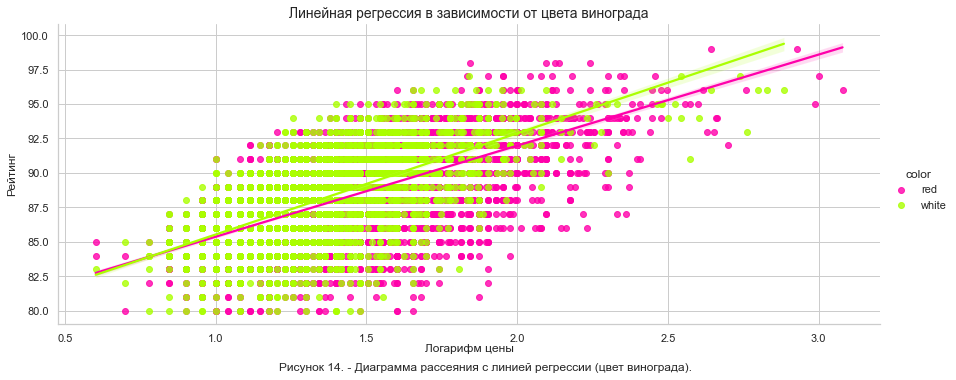

In [138]:
sns.lmplot(x='logprice', y='points', data=wine_rw.sample(frac=0.1), hue='color', palette=winpalette, aspect=2.5);
plt.title('Линейная регрессия в зависимости от цвета винограда', fontsize=14);
plt.xlabel('Логарифм цены', labelpad = 0)
plt.ylabel('Рейтинг');
plt.figtext(0.3, -0.0, "Рисунок 14. - Диаграмма рассеяния с линией регрессии (цвет винограда).");

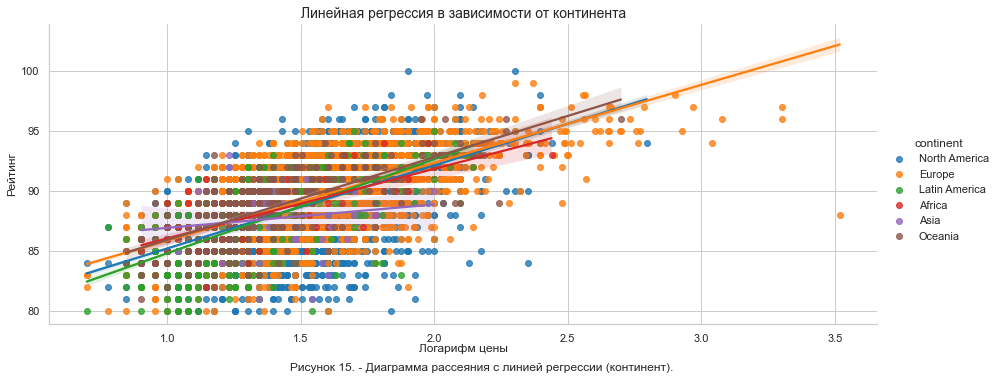

In [139]:
sns.lmplot(x='logprice', y='points', data=wine_rw.sample(frac=0.1), hue='continent', aspect=2.5);
plt.title('Линейная регрессия в зависимости от континента', fontsize=14);
plt.xlabel('Логарифм цены', labelpad = 0)
plt.ylabel('Рейтинг');
plt.figtext(0.3, -0.0, "Рисунок 15. - Диаграмма рассеяния с линией регрессии (континент).");

**ВЫВОД**  
Имеется явно выраженная связь меджу рейтингом вина и его ценой. 
Влияние на эту связь географического региона  незначительно, хотя тренд "вина Америк дешевле в низких рейтингах, чем вина Европы" отметить можно.  
Вияние цвета вина также незначительно, однако тренд "белые вина дороже красных при равных рейтингах" отметить можно.

#  <a name="3">3. Анализ рынка вина по регионам</a>
<a href="#b0"> назад </a> 

<a name = "b3"> </a>
<a href = "#3.1"> 3.1 Оптимизация разбиения на регионы для дальнейшего анализа (введение нового признака).</a>  
<a href = "#3.2"> 3.2 Оптимизация разбиения на рейтинги (введение нового признака).</a>  
<a href = "#3.3"> 3.3 Влияет ли рейтинг на цены по регионам? </a>


В пункте 2.7 нам не удалось установить зависимость цен и рейтингов вин от регионов. Попробуем следать более глубокий анализ, разбив наши данные новыми способами.

<h3><a name = "3.1"> 3.1 Оптимизация разбиения на регионы для дальнейшего анализа (введение нового признака).</a>  </h3>
<a href = "#3"> назад </a>

Введем новый признак wreg (world region), с помощью которого отделим крупнейшие и выделяющиеся винопроизводящие страны от остальных. Поставим этот признак равным continent, за исключением: США, Италии, Франции, Испании. Впрочем, в Северной Америке тогда останется только Канада - присоединим ее к США.   
Кроме того, выделим в Европе регион DACH (немецкоговорящие страны Германия, Австрия, Швейцария) - как мы видели в предварительном исследовании, вина этих стран выделяются высокими рейтингами и, возможно, заслуживают дополнительной оценки.  

In [141]:
wine['wreg'] = wine['continent']
list1 = ['France', 'Italy', 'Spain']
wine.loc[wine['country'].isin(list1), 'wreg'] = wine.loc[wine['country'].isin(list1), 'country']
wine.loc[wine['wreg']=='North America', 'wreg'] = 'US&Canada'
list2 = ['Switzerland', 'Germany', 'Austria']
wine.loc[wine['country'].isin(list2), 'wreg'] = 'DACH'

In [142]:
wine.wreg.unique()

array(['Europe', 'US&Canada', 'Spain', 'Italy', 'France', 'DACH',
       'Latin America', 'Oceania', 'Africa', 'Asia'], dtype=object)

In [143]:
regpalette = {
    'Italy':'g',
    'France': 'r', 
    'Spain':'orange', 
    'DACH':'brown', 
    'Africa':'grey', 
    'US&Canada':'pink',
    'Latin America':'b' ,
    'Oceania':'c',
    'Europe':'m',
    'Asia':'y'
}

regorder=['Italy', 'France', 'Spain', 'DACH', 'Europe', 'Asia', 'Africa', 'Latin America','Oceania','US&Canada']

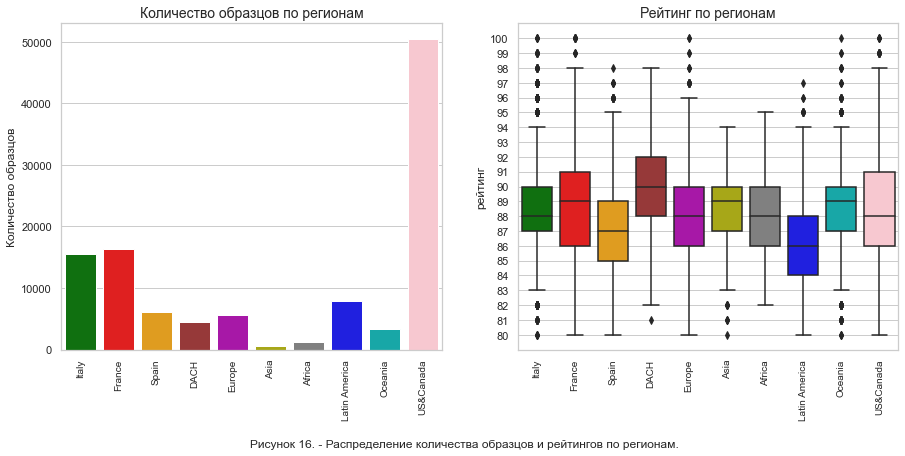

In [144]:
plt.figure()
plt.subplot(1, 2, 1)
sns.countplot(data=wine, x='wreg', palette=regpalette, order=regorder);
plt.title('Количество образцов по регионам', fontsize=14);
plt.xticks(rotation=90, fontsize=10);
plt.ylabel('Количество образцов');
plt.xlabel('')
plt.subplot(1, 2, 2)
sns.boxplot(x='wreg', y='points', data=wine, palette=regpalette, order=regorder);
plt.xticks(rotation=90, fontsize=10);
plt.yticks(ticks=range(80, 101))
plt.title('Рейтинг по регионам', fontsize=14);
plt.xlabel('')
plt.ylabel('рейтинг');
plt.figtext(0.3, -0.1, "Рисунок 16. - Распределение количества образцов и рейтингов по регионам.");

Такое региональное разделение точнее отражает мировые тенденции в виноделии, рассмотренные в п. 2.1 на основании статистических данных ООН, и полученные нами в предварительном исследовании выводы.

<h3><a name = "3.2"> 3.2 Оптимизация разбиения на рейтинги (введение нового признака).</a>  </h3>
<a href = "#3"> назад </a>

Введем категории по рейтингу для осуществления перекрестного анализа рейтинг-регион. 

Создадим признак 'rate' и и присвоим винам с рейтингам ниже .25 перцентиля значение 'low', между .25 и .75 -  значение 'mid' и выше .75 - значение 'hi'.

In [145]:
wine['rate'] = pd.qcut(wine.points, [0, 0.25, 0.75, 1], labels=['low', 'mid', 'hi'])

Создадим функцию, визуализирующую распределение рейтингов по регионам. Функция обращается к глобальным переменным, т.е. не может быть перенесена в другое окружение и выполняет технические функции в рамках данного проекта.

In [157]:
def plot_rate_vol(rate, pricelim, plotnum=0):
    """draw price and volume diagrams by regions for choosen rate
    based on palette and order defined outside"""
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    sns.boxplot(x='wreg', y='price', data=wine.query('rate==@rate'),palette=regpalette, order=regorder)
    plt.title('Распределение цен', fontsize=14);
    plt.ylim((0, pricelim))
    plt.xticks(rotation=60)
    plt.xlabel('')
    plt.ylabel('Цена');
    plt.subplot(1, 2, 2)
    sns.countplot(x='wreg', data=wine.query('rate==@rate'),palette=regpalette, order=regorder)
    plt.title('Распределение образцов', fontsize=14);
    plt.xticks(rotation=60)
    plt.ylabel('Количество образцов')
    plt.xlabel('')
    plt.figtext(0.3, -0.2, "Рисунок {}. - Распределение цен в рейтинге {}.".format(plotnum, rate));

**ИТОГ**  
Теперь, с проведенным разделением на категории по регионам и рейтингу и созданной функцией визуализации, мы готовы к следующему шагу анализа.

<h3><a name = "3.3"> 3.3 Влияет ли рейтинг на цены по регионам?</a>  </h3>
<a href = "#3"> назад </a>

Визуализируем распределение цен в зависимости от рейтингов по регионам, а также объемы предложения в данных регионах(как мы знаем из предыдущего исследования, наши данные довольно адекватно соответствуют объемам производства вин во всех регионах, за исключением США и Китая/Азии) 

**Анализ вин с низким рейтингом:**

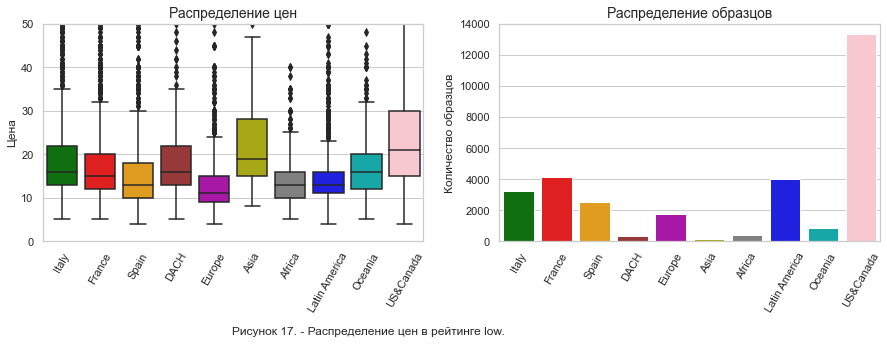

In [158]:
plot_rate_vol('low', 50, 17)    

**ВЫВОД**  
Для низкорейтинговых вин интереснее смотреть на Испанию среди грандов Старого Света и на вина Латинской Америки, также можно поискать среди вин "второстепенных" стран Европы. В этих регионах большое предложение и низкие медианные цены.  

Африка привлекательна по цене, но предложение невелико. Может быть точкой приложения усилий для "венчурного" закупщика.  

Италия, Франция, немецкоязычные страны, Океания (Австралия) и США/Канада выглядят в сегменте низкорейтинговых вин как overpriced.

<br>

**Анализ вин с средним рейтингом:**

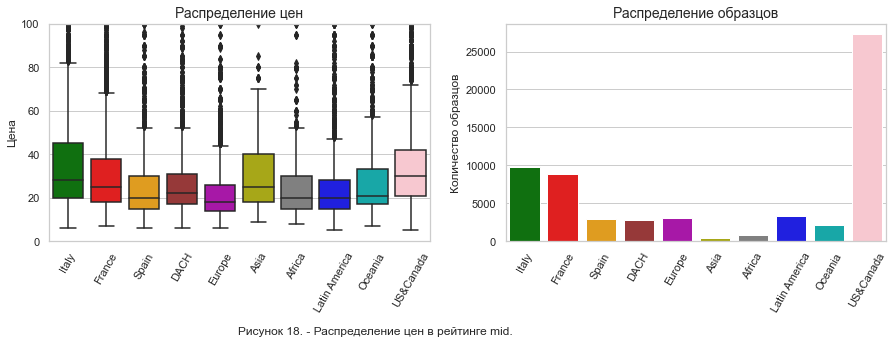

In [159]:
plot_rate_vol('mid', 100, 18)    

**ВЫВОД**  
Для среднерейтинговых вин интересны вина всей Европы с определенной спецификой по регионам.  
Гранды Старого Света: Италия и Франция - большое предложение, цены выше. Испания по-прежнему выделяется более низкими ценами при неплохом предложении. Немецкоязычные страны: предложение достаточно обширно, цены на уровне "грандов". Второстепенные страны предлагают много вин по более низким ценам.

Африка - предложение мало, предмет интереса для еще более рискового байера, чем в низком сегменте.

Латинская Америка, Океания (Австралия) - обширное предложение, цены на "нижнем" уровне Европы. Вопрос логистики и маркетинга: продать вино Чили по цене Испании легче в низком сегменте, чем в среднем.

США-Канада выглядят overpriced.


<br>

**Анализ вин с высоким рейтингом:**

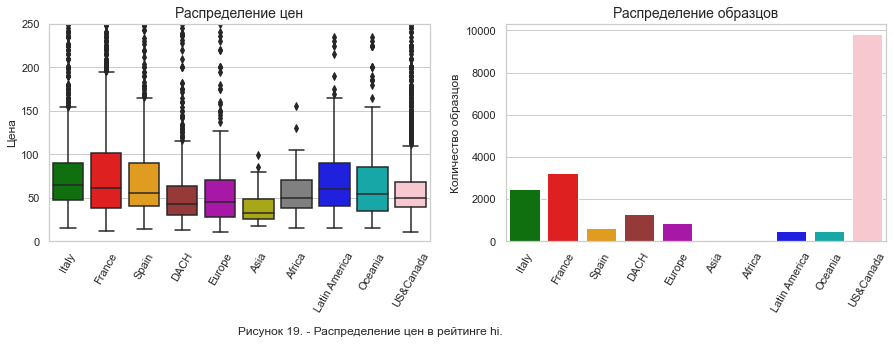

In [160]:
plot_rate_vol('hi', 250, 19)    

**ВЫВОД**  
Среди грандов Старого Света наибольший выбор высокорейтинговых вин Италии и Франции, при сравнимой цене. В этом сегменте становятся очень привлекательны немецкоязычные страны с обширным предложением и умеренной ценой. Второстепенная Европа также выглядит перспективной.

В Новом Свете - есть обширное предложение в Океании (Австралии) по ценам ниже европейских. Может быть возможностью для бизнеса (но придется конкурировать с закупщиками из Китая)

США и Канада - судя по данному отчету, отличное предложение по низким ценам. Однако, принимая во внимание, во-первых, тенденциозность отчета (см. раздел 2), и, во-вторых, современное международное положение, от рекомендаций для бизнеса в этом случае лучше воздержаться.

#  <a name="4"> 4. Исследование зависимости рейтинга вина от цены и других признаков.</a>
<a href="#b0"> назад </a> 

<a name = "b4"> </a>
<a href = "#4.1"> 4.1 Подготовка данных и инструментов для построения модели.</a>  
<a href = "#4.2"> 4.2 Построение и проверка модели линейной регрессии.</a>  
<a href = "#4.3"> 4.3 Построение усложненной модели. </a>


Построим линейную регрессию зависимости между ценой вина и его рейтингом.
Как уже было показано в п. 2.7, более высокая корреляция наблюдается между рейтингом и логарифмом цены. Будем включать в модель сразу оба параметра в качестве независимых переменных.

Зависимая переменная - рейтинг ('points').


<h3><a name = "4.1"> 4.1 Подготовка данных и инструментов для построения модели.</a>  </h3>
<a href = "#4"> назад </a>

Посмотрим еще раз на данные:

In [161]:
wine.describe().T

,count,mean,std,min,25%,50%,75%,max
points,111537.0,88.413809,3.099243,80.00000,86.000000,88.00000,91.000000,100.000000
price,111537.0,35.626276,42.113062,4.00000,17.000000,25.00000,42.000000,3300.000000
logprice,111537.0,1.440556,0.286394,0.60206,1.230449,1.39794,1.623249,3.518514


In [162]:
def plot_char_pict(df, char, reg, plotnum=0):
    '''general boxplot, divided by reg boxplot, histogram
    '''
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    sns.boxplot(data=df, y=char)
    plt.subplot(1, 3, 2)
    sns.boxplot(data=df, y=char, x=reg)
    plt.xticks(rotation=90, fontsize=10);
    plt.xlabel('')
    plt.subplot(1, 3, 3)
    sns.histplot(data=df, x=char);
    plt.figtext(0.3, -0.2, "Рисунок {}. - Распределение параметра {} по регионам.".format(plotnum, char));

Создадим функцию, визуализирующую данные с разбивкой по регионам. Функция НЕ обращается к глобальным переменным, т.е. может быть использована за рамками данного проекта.

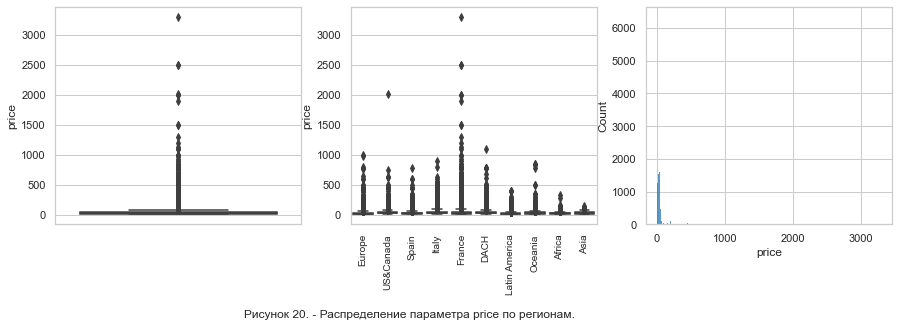

In [163]:
plot_char_pict(wine, 'price', 'wreg', 20);

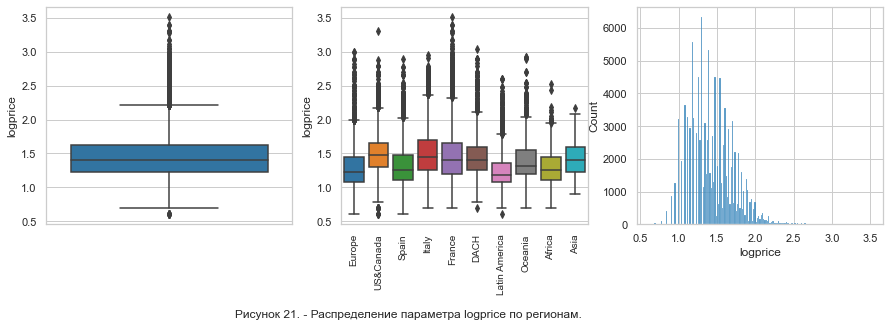

In [164]:
plot_char_pict(wine, 'logprice', 'wreg', 21);

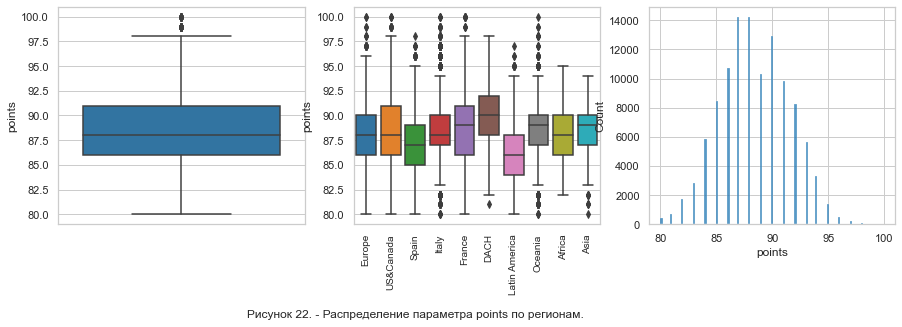

In [165]:
plot_char_pict(wine, 'points', 'wreg', 22);

Посмотрим еще диаграмму рассеяния:

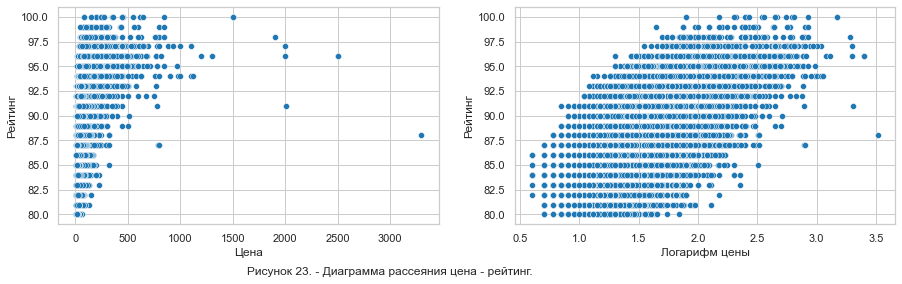

In [166]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(data=wine, x='price', y='points');
plt.xlabel('Цена')
plt.ylabel('Рейтинг');
plt.subplot(1, 2, 2)
sns.scatterplot(data=wine, x='logprice', y='points');
plt.xlabel('Логарифм цены')
plt.ylabel('Рейтинг');
plt.figtext(0.3, -0.05, "Рисунок 23. - Диаграмма рассеяния цена - рейтинг.");

Из визуализаций выше видно, 
- распределение рейтингов похоже на нормальное,
- в цене есть много выбросов вверх, которые могут отрицательно повлиять на качество модели,
- распределние логарифмированной цены похоже на нормальное, хоть и с длинным хвостом справа.  

Создадим новый датафрейм wine_c, обрезав цены по 99% перцентилю, и посмотрим на результат.

In [167]:
wine_c = wine[wine.price <= wine.price.quantile(0.99)].copy()

In [168]:
wine_c.describe().T

,count,mean,std,min,25%,50%,75%,max
points,110457.0,88.359805,3.054562,80.00000,86.000000,88.00000,91.000000,100.00000
price,110457.0,33.000226,23.340868,4.00000,17.000000,25.00000,42.000000,160.00000
logprice,110457.0,1.430934,0.269966,0.60206,1.230449,1.39794,1.623249,2.20412


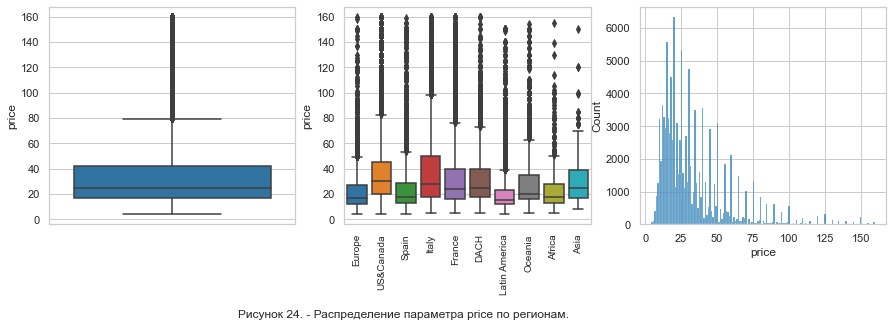

In [169]:
plot_char_pict(wine_c, 'price', 'wreg', 24);

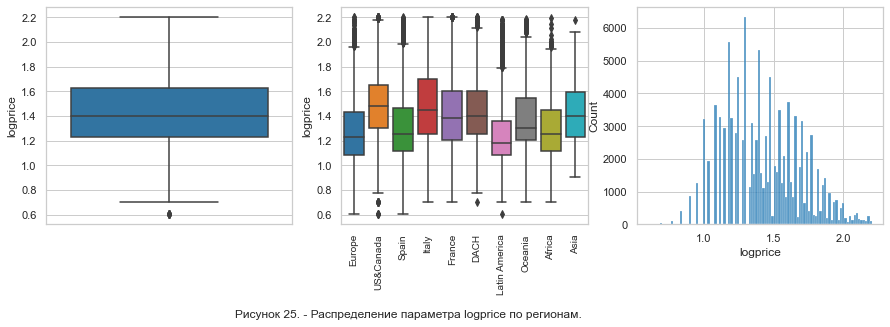

In [170]:
plot_char_pict(wine_c, 'logprice', 'wreg', 25);

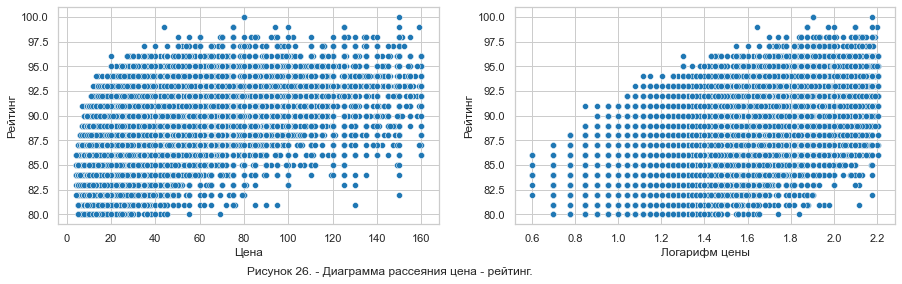

In [171]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(data=wine_c, x='price', y='points');
plt.xlabel('Цена')
plt.ylabel('Рейтинг');
plt.subplot(1, 2, 2)
sns.scatterplot(data=wine_c, x='logprice', y='points');
plt.xlabel('Логарифм цены')
plt.ylabel('Рейтинг');
plt.figtext(0.3, -0.05, "Рисунок 26. - Диаграмма рассеяния цена - рейтинг.");

**С такими данными** строить регрессию намного интереснее.  
Распределение логарифма цены похоже на нормальное, распределение цены скошено влево, но без резких выбросов и пропусков.  
Принимаем wine_c к обработке.

<h3><a name = "4.1"> 4.2 Построение и проверка модели линейной регрессии.</a>  </h3>
<a href = "#4"> назад </a>

Загрузка библиотек и метрик:

In [172]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE, r2_score

Подготовим функцию для подсчета и вывода метрик:

In [174]:
def print_metrics(y_train, y_test, y_p_train, y_p_test):
    """ prints quality metrics for prediction
    """
    Mtrain = (round(MSE(y_train, y_p_train)**0.5, 3), round(MAE(y_train, y_p_train), 3),
              round(r2_score(y_train, y_p_train), 3))
    Mtest = (round(MSE(y_test, y_p_test)**0.5, 3), round(MAE(y_test, y_p_test), 3), 
             round(r2_score(y_test, y_p_test), 3))
              
    print('Test MSE:', Mtest[0],' MAE:', Mtest[1],' R2:', Mtest[2], end='; ')
    print('Train MSE:', Mtrain[0],' MAE:', Mtrain[1], ' R2:', Mtrain[2])
    return Mtest, Mtrain
    

Подготовим функцию для визуализации:

In [175]:
def visual_model(X_tr, X_tst, y_tr, y_tst, y_pr, plotnum=0):
    
    """Draw scatter and predicted (test) line
    """
    plt.figure(figsize=(15, 4))
    plt.scatter(X_tr, y_tr, color = 'b', label = 'Train', alpha=0.3);
    plt.scatter(X_tst, y_tst, color = 'm', label = 'Test', alpha=0.3);
    plt.scatter(X_tst, y_pr, color = 'g', label = 'Predict');
    plt.xlabel('Цена')
    plt.ylabel('Рейтинг');
    plt.figtext(0.3, -0.05, "Рисунок {}. - Проверка регрессионной модели.".format(plotnum));
    plt.legend();

Выделим независимые признаки (цена и ее логарифм) в X и целевой (зависимый) признак (рейтинг) в Y

In [176]:
X = wine_c[['price', 'logprice']]
y = wine_c['points']

Разделим выборку на тренировочную и тестовую

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state = 123)

Обучим модель и проверим на тестовой выборке:

In [178]:
linmodel = LinearRegression()
linmodel.fit(X_train, y_train)

y_tr_predict = linmodel.predict(X_train)
y_test_predict = linmodel.predict(X_test)

Посмотрим точность:

In [179]:
metrics_1 = print_metrics(y_train, y_test, y_tr_predict, y_test_predict)

Test MSE: 2.444  MAE: 1.947  R2: 0.361; Train MSE: 2.425  MAE: 1.928  R2: 0.369


И посмотрим визуализацию:

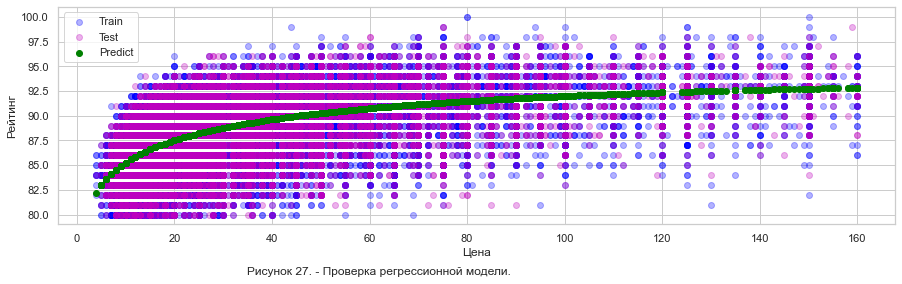

In [180]:
visual_model(X_train.price, X_test.price, y_train, y_test, y_test_predict, 27)

И посмотрим получившиеся коэффициенты ререссии:

In [181]:
print(X.columns) 
print('{:.3f}, {:.3f}'.format(linmodel.coef_[0], linmodel.coef_[1]))

Index(['price', 'logprice'], dtype='object')
-0.013, 7.890


Коэффициент при price близок к 0, т.е. вся закономерность строится на логарифме цены. Можно было столбец цены вообще не использовать.

<h3><a name = "4.3"> 4.3 Построение усложненной модели.</a>  </h3>
<a href = "#4"> назад </a>

Добавим в модель цвет и регион, проведем их кодировку в отдельные векторы.  

In [182]:
X1= wine_c[['color', 'wreg']]
X1.nunique()

color     3
wreg     10
dtype: int64

In [183]:
from sklearn.preprocessing import OneHotEncoder
oh_encoder = OneHotEncoder(sparse=False)
X1 = oh_encoder.fit_transform(X1)
X1 = pd.DataFrame(X1, index=X.index).astype('int')
X1.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12
1,0,1,0,0,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,1


In [184]:
X2 = pd.concat([X, X1], axis = 'columns')
X2.head(2)

,price,logprice,0,1,2,3,4,5,6,7,8,9,10,11,12
1,15.0,1.176091,0,1,0,0,0,0,1,0,0,0,0,0,0
2,14.0,1.146128,0,0,1,0,0,0,0,0,0,0,0,0,1


Добавили в модель 12 новых признаков - по одному на каждый цвет и регион. Получили большую, но сильно разреженную матрицу.

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, train_size=0.7, random_state = 123)

In [186]:
linmodel = LinearRegression()
linmodel.fit(X_train, y_train)

y_tr_predict = linmodel.predict(X_train)
y_test_predict = linmodel.predict(X_test)

In [187]:
metrics_2 = print_metrics(y_train, y_test, y_tr_predict, y_test_predict)
metrics_1

Test MSE: 2.397  MAE: 1.909  R2: 0.385; Train MSE: 2.378  MAE: 1.891  R2: 0.393


((2.444, 1.947, 0.361), (2.425, 1.928, 0.369))

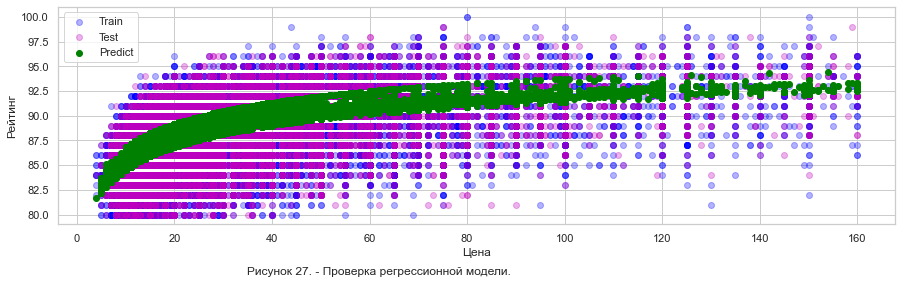

In [189]:
visual_model(X_train.price, X_test.price, y_train, y_test, y_test_predict, 27)

Добавление признаков улучшило качество модели: R2 на тестовой выборке увеличился на 7%, с 0.361 до 0.385. 

**ВЫВОД**  
Установив коррреляцию между ценой и рейтингом, мы взялись строить модель линейной регрессии. Ожидаемо более высокое качество предсказания было обеспечено при добавлении в качестве независимого параметра логарифмированной цены. Добавление дополнительных категориальных признаков позволило еще улучшить качество модели на 5%.  

#  <a name="5">5. Проверка гипотез </a>
<a href="#b0"> назад </a> 

<a name = "b4"> </a>
<a href = "#5.1"> 5.1 Гипотеза о рейтинговых различиях вин по цвету.</a>  
<a href = "#4.2"> 5.2 Гипотеза о ценовых различиях популярных сортов винограда.</a>  

<h3><a name = "5.1"> 5.1 Гипотеза о рейтинговых различиях вин по цвету.</a>  </h3>
<a href = "#5"> назад </a>

В разделе 3 мы исследовали цены и рейтинги белых и красных вин, однако не сделали определенных выводов.  
Выдвинем и проверим гипотезу, сначала исследуем данные:

In [190]:
wine.groupby('color').points.describe()

,count,mean,std,min,25%,50%,75%,max
color,,,,,,,,
other,15422.0,87.896641,2.869661,80.0,86.0,88.0,90.0,100.0
red,62798.0,88.699513,3.165886,80.0,87.0,89.0,91.0,100.0
white,33317.0,88.114686,3.014307,80.0,86.0,88.0,90.0,100.0


Можно предположить, что средние рейтинги красного вина выше, но гипотеза требует проверки.  

* H0: Средние пользовательские рейтинги красного и белого вина одинаковые.
* H1:Средние пользовательские рейтинги красного и белого вина разные, рейтинги красного выше.

Исключим из рассмотрения 'other' (переменная wine_rw заведена ранее).

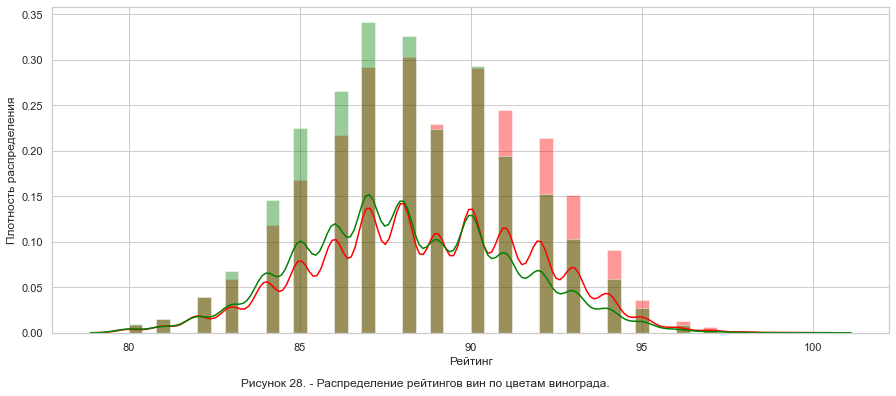

In [191]:
sns.distplot(wine_rw.query('color=="red"').points, color = 'r')
sns.distplot(wine_rw.query('color=="white"').points, color='g');
plt.xlabel('Рейтинг')
plt.ylabel('Плотность распределения');
plt.figtext(0.3, -0.0, "Рисунок 28. - Распределение рейтингов вин по цветам винограда.");

Распределения рейтингов похожи на нормальные, размеры выборок велики ( > 1000).  
Используем T-тест, зададим alpha 0.05.   
Дисперсии различаются (на основании  различий стандартных отклонений).

In [195]:
alpha = 0.05

results = st.ttest_ind(wine.query('color == "red"').points, 
                       wine.query('color == "white"').points, equal_var=False,
                      alternative='greater')
print('Pvalue =', round(results.pvalue, 4))

if (results.pvalue < alpha):
    print("Отклоняем нулевую гипотезу")
else:
    print("Не получилось отклонить нулевую гипотезу")

Pvalue = 0.0
Отклоняем нулевую гипотезу


**ВЫВОД** Есть основания отклонить нулевую гипотезу о равенстве средних рейтингов красного и белого вин.

На основании имеющихся данных можно принять гипотезу, что средние рейтинго красных вин выше.

<h3><a name = "5.2"> 5.2 Гипотеза о ценовых различиях популярных сортов винограда.</a>  </h3>
<a href = "#5"> назад </a>

Сравним средние цены на вина из двух популярных сортов винограда одного цвета (красного). Выберем популярные сорта:

In [196]:
redlist=wine.query('color=="red"').variety.value_counts().head(10).index

In [197]:
wine[wine.variety.isin(redlist)].groupby('variety').price.describe()

,count,mean,std,min,25%,50%,75%,max
variety,,,,,,,,
Bordeaux-style Red Blend,4958.0,48.051230,95.978657,7.0,20.0,30.0,50.0,3300.0
Cabernet Sauvignon,8761.0,48.256820,41.618956,4.0,20.0,38.0,65.0,625.0
Malbec,2391.0,30.163112,27.450300,5.0,15.0,22.0,35.0,400.0
Merlot,2855.0,29.272504,32.977546,4.0,15.0,24.0,35.0,625.0
Nebbiolo,2159.0,66.297360,43.916727,12.0,44.0,57.0,78.0,595.0
Pinot Noir,11833.0,47.879405,49.088844,5.0,28.0,42.0,55.0,2500.0
Red Blend,7800.0,36.094744,30.846253,5.0,18.0,28.0,45.0,500.0
Sangiovese,2163.0,45.411466,43.816980,6.0,22.0,32.0,58.0,800.0
Syrah,3778.0,39.052673,27.317442,4.0,25.0,35.0,45.0,750.0


Bordeaux-style Red Blend и Cabernet Sauvignon - хорошие кандидаты на сравнение, средние цены равны, а медианные заметно различаются.

Выдвинем гипотезу:

* H0:Средние цены на вина из Bordeaux-style Red Blend и Cabernet Sauvignon одинаковые.
* H1:Средние цены на вина этих сортов разные.

In [198]:
wine_BC = wine[wine.variety.isin(['Bordeaux-style Red Blend', 'Cabernet Sauvignon'])].copy()

In [199]:
wine_BC.groupby('variety').price.describe()

,count,mean,std,min,25%,50%,75%,max
variety,,,,,,,,
Bordeaux-style Red Blend,4958.0,48.05123,95.978657,7.0,20.0,30.0,50.0,3300.0
Cabernet Sauvignon,8761.0,48.25682,41.618956,4.0,20.0,38.0,65.0,625.0


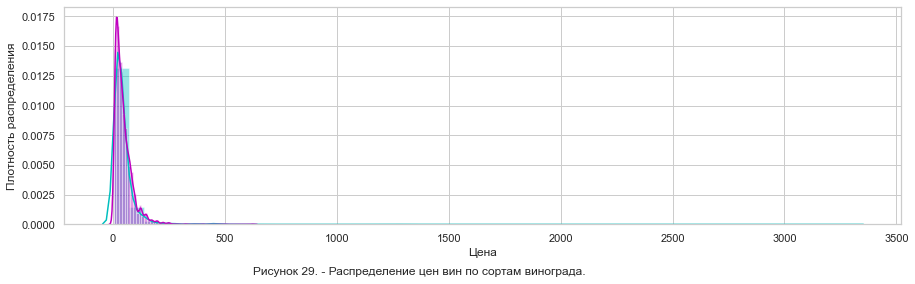

In [200]:
plt.figure(figsize=(15, 4))
sns.distplot(wine_BC.query('variety == "Bordeaux-style Red Blend"').price, color='c')
sns.distplot(wine_BC.query('variety == "Cabernet Sauvignon"').price, color='m');
plt.xlabel('Цена')
plt.ylabel('Плотность распределения');
plt.figtext(0.3, -0.05, "Рисунок 29. - Распределение цен вин по сортам винограда.");

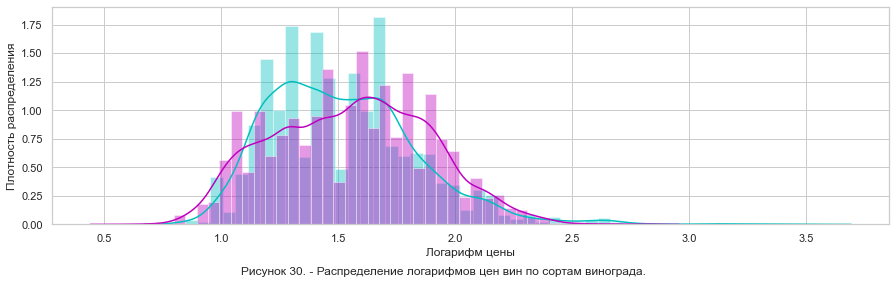

In [201]:
plt.figure(figsize=(15, 4))
sns.distplot(wine_BC.query('variety == "Bordeaux-style Red Blend"').logprice, color='c')
sns.distplot(wine_BC.query('variety == "Cabernet Sauvignon"').logprice, color='m');
plt.xlabel('Логарифм цены')
plt.ylabel('Плотность распределения');
plt.figtext(0.3, -0.05, "Рисунок 30. - Распределение логарифмов цен вин по сортам винограда.");

Дисперсии разные, распределения без резких выбросов, размеры выборок велики ( > 1000).
Используем T-тест, зададим alpha 0.05.

In [202]:
alpha = 0.05

results2 = st.ttest_ind(wine_BC.query('variety == "Bordeaux-style Red Blend"').price, 
                        wine_BC.query('variety == "Cabernet Sauvignon"').price, equal_var=False)

print('Pvalue =', round(results2.pvalue, 4))

if (results2.pvalue < alpha):
    print("Отклоняем нулевую гипотезу")
else:
    print("Не получилось отклонить нулевую гипотезу")

Pvalue = 0.886
Не получилось отклонить нулевую гипотезу


**ВЫВОД** Нет оснований отклонить нулевую гипотезу о равенстве средних цен на вина из этих сортов винограда.  

# <a name="6">6. Выводы</a>
<a href="#b0"> назад </a> 

**На этапе подготовки данных** в исходном наборе были удалены дубликаты и исключены признаки, не существенные для целей проводимого анализа.  
Был проведен анализ пропущенных данных по цене. Оказалось, что в винах с низким и средним рейтингом доля таких пропусков невелика, а в винах с высокими рейтингами - велика, но в основном состоит из образцов, не поступавших в торговую сеть ("Barrel sample"), и цена на них не определялась. Принято решение исключить записи с пропущенной ценой из дальнейшего рассмотрения, т.к. информации о продукции массового сегмента они нам не добавят, а информацию для их восстановления в верхнем сегменте взять неоткуда, и любые фантазии только исказят общую картину.

После проведения "чистки" данных размер таблицы сократился с ~130 000 до ~111 000 записей.

#### Добавлены новые признаки:
 - цвет (color). Для добавления признака "цвет" была проведена экспертная сортировка наиболее часто встречающихся в наборе сортов винограда.
 - континент (continent). В процессе присвоения признака "континент" была выявлена и исправлена ошибка в данных.
 - логарифм цены (logprice).
 - регион (wreg). Выделены крупнейшие винопроизводящие страны Старого Света.
 - рейтинг (rate). Оценка points объединена в 3 более крупные категории.

#### Проведено сравнение набора данных с данными о мировых объемах производства вина, 
источник *Продовольственная и сельскохозяйственная организация Объединенных Наций* https://www.fao.org/faostat/ru/#home

Установлено, что в наших данных по рейтингу вин представленность стран не соответствует их значимости в мировом производстве вина. По-видимому, связано с американским происхождением этих данных: доля образцов из США непропорционально велика и никак не соответствует месту США в мировом производстве вина.  
При этом три основных мировых производителя (Италия, Франция, Испания) представлены достаточно широко и адекватно, да и вообще из крупных производителей плохо представлен только Китай. Что, по-видимому, связано с тем, что емкий внутренний рынок этой страны потребляет всё, что производится и экспорт незначителен.  
Этот информация не ставит под сомнение качество исследуемого набора данных, но требует внимания при интерпретации результатов, в которых влияние образцов из США играет существенную роль. 

#### Анализ популярности сортов винограда в отдельных регионах 
Как правило, популярные сорта винограда специфичны для региона. Хотя некоторые сорта, такие, как Chardonay и Cabernet Sauvignon, широко распространены по всему миру.  
На примере сорта Chardonay показано, что одни и те же популярные сорта винограда могут использоваться для изготовления вин различных ценовых и рейтинговых диапазонов.  
Показано также, что некоторые региональные сорта (испанский сорт Nebbiolo, немецко-австрийский Gruener Veltliner, французский Champagne Blend), дают в среднем вина более высоких рейтингов, чем более "интернациональные" сорта.

#### Установлена выраженная связь 
между рейтингом вина и его ценой с корреляцией, превышающей 0.6 (для логарифма цены).  
Влияние на эту связь географического региона незначительно, хотя можно выделить тренд "вина Америк
дешевле в низких рейтингах".  
Влияние цвета вина также незначительно, но можно выделить тренд тренд "белые вина дороже красных при равных рейтингах".

#### Сформированы рекомендации для закупщиков относительно предпочтительных регионов
**Для низкорейтинговых вин** интереснее смотреть на Испанию среди грандов Старого Света и на вина Латинской Америки, также можно поискать среди вин "второстепенных" стран Европы. В этих регионах большое предложение и низкие медианные цены.  
Африка привлекательна по цене, но предложение невелико. Может быть точкой приложения усилий для "венчурного" закупщика.  
Италия, Франция, немецкоязычные страны, Океания (Австралия) и США/Канада выглядят в сегменте низкорейтинговых вин как overpriced.

**Для среднерейтинговых вин** интересны вина всей Европы. Гранды Старого Света: Италия и Франция - большое предложение, цены выше. Испания - более низкие цены при неплохом предложении. Немецкоязычные страны: предложение достаточно обширно, цены на уровне "грандов". Второстепенные страны предлагают много вин по более низким ценам.  
Африка - предложение мало, предмет интереса для еще более рискового байера, чем в низком сегменте.  
Латинская Америка, Океания (Австралия) - обширное предложение, цены на "нижнем" уровне Европы. Вопрос логистики и маркетинга: продать вино Чили по цене Испании легче в низком сегменте, чем в среднем.  
США-Канада выглядят overpriced.

**Для высокорейтинговых вин** среди грандов Старого Света наибольший выбор  Италии и Франции, при этом вина Италии дешевле. Очень привлекательны немецкоязычные страны с обширным предложением и умеренной ценой.  
В Новом Свете - есть обширное предложение в Океании (Австралии) по ценам ниже европейских. Может быть возможностью для бизнеса (но придется конкурировать с закупщиками из Китая).  
США и Канада - судя по данному отчету, отличное предложение по низким ценам. Однако, принимая во внимание, во-первых, тенденциозность отчета (см. раздел 2), и, во-вторых, современное международное положение, от рекомендаций для бизнеса воздержимся.

#### Построена модель линейной регрессии
Установив корреляцию между ценой и рейтингом, построили модель линейной регрессии. Более высокое качество предсказания было (ожидаемо) обеспечено при добавлении в качестве независимого параметра логарифмированной цены. Добавление дополнительных категориальных признаков позволило улучшить качество модели еще на 5%. 

#### Выдвинуты и проверены статистические гипотезы:

- О равенстве средних пользовательские рейтингов красного и белого вина:  
нулевая гипотеза отвергнута, показано, что превышение среднего рейтинга красных вин над белыми статистичесви значимо.
        
        
- О равенстве средних цен на вина из Bordeaux-style Red Blend и Cabernet Sauvignon:  
оснований для отклонения нулевой гипотезы нет, различия в средних ценах не оказались статистически значимыми, несмотря на заметные различия в статистиках.